In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

C:\Users\Prasoon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Prasoon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Prasoon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Prasoon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarnin

#  BNN

In [2]:
def placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32,shape=[n_x,None],name='X')
    Y = tf.placeholder(tf.float32,shape=[n_y,None],name='Y')
    return (X,Y)

In [3]:
def forward_propagation(X,layers_dims,param_normal, keep_prob=1.0):
    
    def sample_epsilons(param_normal):
        epsilons_W = []
        epsilons_b = []
        for i in range(len(layers_dims)-1):
            epsilons_W.append(tf.random_normal(shape=tf.shape(param_normal["mu_W"+str(i+1)]), mean=0., stddev=1.0))
            epsilons_b.append(tf.random_normal(shape=tf.shape(param_normal["mu_b"+str(i+1)]), mean=0., stddev=1.0))
        return epsilons_W,epsilons_b

    def transform_rhos(layers_dims,param_normal):
        for i in range(len(layers_dims)-1):
            param_normal["rho_W"+str(i+1)] = softplus(param_normal["rho_W"+str(i+1)])
            param_normal["rho_b"+str(i+1)] = softplus(param_normal["rho_b"+str(i+1)])
        return param_normal

    def make_gaussian_samples(param_normal,layers_dims,epsilons_W,epsilons_b):
        samples_W = []
        samples_b = []
        for i in range(len(layers_dims)-1):
            samples_W.append(tf.add(param_normal["mu_W"+str(i+1)],tf.multiply( param_normal["rho_W"+str(i+1)] , epsilons_W[i])))
            samples_b.append(tf.add(param_normal["mu_b"+str(i+1)] ,tf.multiply( param_normal["rho_b"+str(i+1)] , epsilons_b[i])))
        return samples_W, samples_b

    epsilons_W,epsilons_b = sample_epsilons(param_normal)
    param_normal = transform_rhos(layers_dims,param_normal)
    samples_W, samples_b =  make_gaussian_samples(param_normal,layers_dims,epsilons_W,epsilons_b)
    
    store = {}
    store['A0'] = X
    for l in range(len(layers_dims)-1):
        store["Z"+str(l+1)] = tf.add(tf.matmul(samples_W[l],store["A"+str(l)]),samples_b[l])
        if (l == len(layers_dims) - 2):
            return store["Z"+str(l+1)],samples_W,samples_b
        store["A"+str(l+1)] = tf.nn.sigmoid(store["Z"+str(l+1)])
        store["A"+str(l+1)] = tf.nn.dropout(store["A"+str(l+1)], keep_prob)

In [4]:
def initialization(layers_dims):
    param_normal = {}
    for l in range(len(layers_dims)-1):
        param_normal["mu_W"+str(l+1)] = tf.get_variable('mu_W'+str(l+1),[layers_dims[l+1],layers_dims[l]],initializer =  tf.random_normal_initializer(mean = 0.0,stddev = 0.1))
        param_normal["rho_W"+str(l+1)] = -15.5 + tf.get_variable("rho_W"+str(l+1),[layers_dims[l+1],layers_dims[l]],initializer = tf.zeros_initializer())
        param_normal["mu_b"+str(l+1)] = tf.get_variable('mu_b'+str(l+1),[layers_dims[l+1],1],initializer =  tf.random_normal_initializer(mean = 0.0,stddev = 0.1))
        param_normal["rho_b"+str(l+1)] =  -16.5 + tf.get_variable("rho_b"+str(l+1),[layers_dims[l+1],1],initializer = tf.zeros_initializer())
    return param_normal 

In [5]:
def softplus(x):
    return tf.log(1.0 + tf.exp(x))

In [6]:
def log_gaussian(x, mu,sigma):
    return -0.5 * tf.log(2.0 * tf.constant(math.pi)) - tf.log(sigma) - tf.truediv(tf.multiply((x-mu),(x-mu)), (2.0 * tf.multiply(sigma,sigma)))

In [7]:
def prior(x):
    mean_prior = tf.constant(0.0)
    sigma_prior = tf.constant(1.0)
    return tf.reduce_sum(log_gaussian(x,mean_prior,sigma_prior))

In [8]:
def gaussian(x,mu,sigma):
    scaling = tf.truediv(1.0,tf.sqrt(2.0 * tf.constant(math.pi) * tf.multiply(sigma,sigma)))
    bell = tf.exp(-1.0 * tf.truediv(tf.multiply((x-mu),(x-mu)), (2.0 * tf.multiply(sigma,sigma))))
    return tf.multiply(scaling,bell)

In [9]:
def log_softmax_likelihood(ZL, y):
    return  -1 * tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y),logits=tf.transpose(ZL),))

In [10]:
def compute_cost(layers_dims,samples_W,samples_b,param_normal,ZL,label_one_hot):
    log_likelihood_sum = log_softmax_likelihood(ZL, label_one_hot)
    log_prior_list = []
    log_var_posterior_list = []
    for i in range(len(layers_dims)-1):
        log_prior_list.append(prior(samples_W[i]))
        log_prior_list.append(prior(samples_b[i]))
        log_var_posterior_list.append(tf.reduce_sum(log_gaussian(samples_W[i],param_normal["mu_W"+str(i+1)],param_normal["rho_W"+str(i+1)])))
        log_var_posterior_list.append( tf.reduce_sum(log_gaussian(samples_b[i],param_normal["mu_b"+str(i+1)],param_normal["rho_b"+str(i+1)])))
    log_prior_sum = sum(log_prior_list)
    log_var_posterior_sum = sum(log_var_posterior_list)
    return 1/(X_train.shape[1]) * (log_var_posterior_sum - log_prior_sum -  log_likelihood_sum)#log_likelihood_sum #(log_var_posterior_sum - log_prior_sum -  log_likelihood_sum)   #((log_var_posterior_sum - log_prior_sum) 

In [11]:
def model(X_train,Y_train,X_test,Y_test,learning_rate,num_epochs,print_cost,layers_dims):
    tf.reset_default_graph()
    tf.set_random_seed(1234)
    n_x = X_train.shape[0]
    m = X_train.shape[1]
    n_y = Y_train.shape[0]
    costs =[]
    (X,Y) = placeholders(n_x,n_y)
    param_normal = initialization(layers_dims)
    ZL,samples_W,samples_b = forward_propagation(X,layers_dims,param_normal)
    loss = compute_cost(layers_dims,samples_W,samples_b,param_normal,ZL,Y_train)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss) 
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            _,epoch_cost = sess.run([optimizer,loss],feed_dict={X : X_train, Y : Y_train})
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        logit_final_temp = tf.nn.softmax(ZL,axis=0)
        list_logit_train = []
        list_logit_test = []
        for pred in range(0,500):
            logit_final_test = logit_final_temp.eval(feed_dict={X: X_test})
            logit_final_train = logit_final_temp.eval(feed_dict = {X: X_train})
            list_logit_train.append(logit_final_train)
            list_logit_test.append(logit_final_test)
            if pred == 0:
                arr_pred_train = np.argmax(logit_final_train, axis= 0)
                arr_pred_test = np.argmax(logit_final_test,axis=0)
                train_accuracy =  np.sum(arr_pred_train == Ytrain) / len(arr_pred_train)
                test_accuracy = np.sum(arr_pred_test == Ytest) / len(arr_pred_test)
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    return [train_accuracy,test_accuracy,list_logit_test,list_logit_train,arr_pred_test,arr_pred_train]

In [12]:
def split_train_test(df_pca2,rs):
    for l in range(31):
        df_temp = df_pca2.loc[df_pca2['label'] == l]
        if l == 0:
            X_train, X_test, y_train, y_test = train_test_split(df_temp.iloc[:,:-1],df_temp.iloc[:,-1], test_size=0.20, random_state=rs)
        else:
            X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(df_temp.iloc[:,:-1],df_temp.iloc[:,-1], test_size=0.20, random_state=rs)
            X_train = pd.concat([X_train,X_train_temp])
            X_test = pd.concat([X_test,X_test_temp])
            y_train = pd.concat([y_train,y_train_temp])
            y_test = pd.concat([y_test,y_test_temp])
    return (X_train, X_test, y_train, y_test)

# Loading the data

In [13]:
df_pca2 = pd.read_csv('D:/New folder/100_genes_pca2_new.csv')
df_label = pd.read_csv('D:/New Folder/labels.csv',header=1)
label = list(df_label['Abbreviation'])

# Uncertainty Calculation

In [ ]:
def filter_1(logits,y_test,arr_pred_test,type_uncer,t,t_l,image_name):
    
        aleo_list = []
        for j in range(len(logits)):
            prob_list = []
            for i in range(logits[j].shape[1]):
                arg = np.argmax(logits[j][:,i])
                prob = logits[j][:,i][arg]
                prob_list.append(prob)
            aleo = list(np.array(prob_list) - np.square(np.array(prob_list)))
            aleo_list.append(aleo)
            
        epi_list = []
        for j in range(len(logits)):
            prob_list = []
            for i in range(logits[j].shape[1]):
                arg = np.argmax(logits[j][:,i])
                prob = logits[j][:,i][arg]
                prob_list.append(prob)
            epi_list.append(np.array(prob_list))
        epistemic_uncertainty = np.mean(np.square((np.array(epi_list)-np.mean(np.array(epi_list),axis=0))),axis=0)
        aleoteric_uncertainty = np.mean(np.array(aleo_list),axis=0)
        
        uncorrect = []
        for i in range(len(list(arr_pred_test))):
            if (arr_pred_test[i] != np.array(y_test)[i]):
                uncorrect.append(i)
                
        list_aleoteric_correct = []
        list_aleoteric_incorrect = []
        for i in range(len(aleoteric_uncertainty)):
            if (i in uncorrect) == True:
                list_aleoteric_incorrect.append(aleoteric_uncertainty[i])
            if (i in uncorrect) == False:
                list_aleoteric_correct.append(aleoteric_uncertainty[i])
                
        list_epistemic_correct = []
        list_epistemic_incorrect = []
        for i in range(len(epistemic_uncertainty)):
            if (i in uncorrect) == True:
                list_epistemic_incorrect.append(epistemic_uncertainty[i])
            if (i in uncorrect) == False:
                list_epistemic_correct.append(epistemic_uncertainty[i])
                
        corr = np.mean(np.array(list_aleoteric_correct))
        uncorr = np.mean(np.array(list_aleoteric_incorrect))
        corr_epistemic = np.mean(np.array(list_epistemic_correct))
        uncorr_epistemic = np.mean(np.array(list_epistemic_incorrect))
        
        if type_uncer == 'Aleatoric':
            fig = plt.figure()
            ax1 = fig.add_axes([0, 0, 1, 1])
            ax2 = fig.add_axes()
            ax2 = ax1.twinx()
            ax1.tick_params(axis='y', labelcolor='b')
            ax2.tick_params(axis='y', labelcolor='r')

            sns.kdeplot(list_aleoteric_correct,color='b',ax=ax1)
            sns.kdeplot(list_aleoteric_incorrect,color='r',ax=ax2).set(xlim=(0, 0.35))
   
            if t == 'Train':
                plt.axvline(x=corr,c= 'b',linestyle='--',label = 'Mean uncertainty (correct)')
                plt.axvline(x=uncorr, c = 'r',linestyle='--',label = 'Mean uncertainty (incorrect)')
                
            if t == 'Validation':
                plt.axhline(y=corr,c= 'g',label='Mean uncertainty for correct predictions')
                plt.axhline(y=uncorr, c = 'm',label='Mean uncertainty for incorrect predictions')
                plt.legend(bbox_to_anchor=(1,1),prop={'size':10})
   
            if t== 'Test':
                plt.axvline(x=corr, c = 'b',linestyle='--',label= 'Mean test uncertainty (correct)')
                plt.axvline(x=uncorr,c= 'r',linestyle='--',label = 'Mean test uncertaity (incorrect)')
                plt.axvline(x=t_l, c = 'g',linestyle='--',label = 'Mean train uncertainty (correct)')
                
            plt.legend(bbox_to_anchor=(1.6,1))    
            
            ax1.set_ylabel('Density (Correct Predictions)', color='b',fontsize=15)
            ax2.set_ylabel('Density (Incorrect Predictions)', color='r',fontsize=15)

            ax1.set_xlabel('Aleatoric Uncertainty',fontsize = 15)
            fig.savefig('Desktop/paper_figures/'+str(image_name)+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
            plt.show()
            return [aleoteric_uncertainty,corr,uncorr]

        if type_uncer == 'Epistemic':
            fig = plt.figure()
            ax1 = fig.add_axes([0, 0, 1, 1])
            ax2 = fig.add_axes()
            ax2 = ax1.twinx()
            ax1.tick_params(axis='y', labelcolor='b')
            ax2.tick_params(axis='y', labelcolor='r')
            sns.kdeplot(np.array(list_epistemic_correct)*1e9,color='b',ax=ax1)
            sns.kdeplot(np.array(list_epistemic_incorrect)*1e9,color='r',ax=ax2).set(xlim=(0, 2))
   
            if t == 'Train':
                plt.axvline(x=corr_epistemic*1e9, c = 'b',linestyle='--',label = 'Mean uncertainty (correct)')
                plt.axvline(x=uncorr_epistemic*1e9,c= 'r',linestyle='--',label = 'Mean uncertainty (incorrect)')
                
            if t== 'Test':
                plt.axvline(x=corr_epistemic*1e9, c = 'b',linestyle='--',label = 'Mean test uncertainty (correct)')
                plt.axvline(x=uncorr_epistemic*1e9,c= 'r',linestyle='--',label = 'Mean test uncertainty (incorrect)')
                plt.axvline(x=t_l*1e9, c = 'g',linestyle='--',label='Mean train uncertainty (correct)')
                
            plt.legend(bbox_to_anchor=(1.6,1))
            
            ax1.set_ylabel('Density (Correct Predictions)', color='b',fontsize=15)
            ax2.set_ylabel('Density (Incorrect Predictions)', color='r',fontsize=15)
            ax1.set_xlabel('Epistemic Uncertainty (x '+str(r'$10^{-9}$')+')',fontsize = 15)
            #fig.savefig('Desktop/paper_figures/'+str(image_name)+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
            plt.show()
            return [epistemic_uncertainty,corr_epistemic,uncorr_epistemic]

In [14]:
def filter_2(dict_result_train,uncertainty_type,y_test,arr_pred_test,al_test,image_name):
    fig = plt.figure(figsize = (20,20))
    if uncertainty_type == 'Aleatoric':
        fig.text(0.06, 0.5, 'Aleatoric Uncertainty', ha='center', va='center', rotation='vertical',fontsize=30)

    if uncertainty_type == 'Epistemic':
        fig.text(0.06, 0.5, 'Epistemic Uncertainty (x '+str(r'$10^{-9}$')+')', ha='center', va='center', rotation='vertical',fontsize=30)

    cancer_types = ['LAML','ACC','BLCA','LGG','BRCA','CESC','CHOL','COAD','UCEC','ESCA','GBM','HNSC','KIRC','KIRP','LIHC','LUAD','LUSC','DLBC','MESO','OV','PAAD','PCPG','PRAD','READ','SKCM','STAD','TGCT','THYM','THCA','UCS','UVM']
    dict_mean_train = {}
    dict_mean_test_corr = {}
    dict_mean_test_incorr = {}
    for i in range(31):
        
        train = dict_result_train[i][0]
        pred_train = dict_result_train[i][1]
        al_train_temp = dict_result_train[i][2]
        ep_train_temp = dict_result_train[i][3]
        
        ax = fig.add_subplot(7,5,i+1)
        
        list_index = list(np.where(arr_pred_test == i)[0])
        list_index2 = list(np.where(y_test==i)[0])
    
        correct_index = []
        incorrect_index = []
        for j in range(len(list_index)):
            if (list_index[j] in list_index2) == True:
                correct_index.append(j)
            else:
                incorrect_index.append(j)
        
        corr_al = al_test[list(np.array(list_index)[correct_index])]
        incorr_al = al_test[list(np.array(list_index)[incorrect_index])]
        
        list_combined = list(corr_al)+list(incorr_al)
        
        index_temp_incorr = []
        index_temp = []
        for j in range(len(list_combined)):
            index_temp.append(j)
            if (j >= len(corr_al)):
                index_temp_incorr.append(j)
        
        l_final, l_index_final = shuffle(list_combined, index_temp, random_state=0)
        
        uncorrect = []
        for j in range(len(l_index_final)):
            if (l_index_final[j] in index_temp_incorr) ==True:
                uncorrect.append(j)      
            
        correct_train = []
        uncorrect_train = []
        for k in range(len(list(pred_train))):
            if (pred_train[k] != train[k]):
                uncorrect_train.append(k)
            else:
                correct_train.append(k)

        if uncertainty_type == 'Aleatoric':

            corr = np.mean(corr_al)
            uncorr = np.mean(incorr_al)
            corr_train = np.mean(al_train_temp[correct_train])
            bar_list = ax.bar(np.arange(0,len(l_final)),l_final,width=0.1)
            dict_mean_train[i] = corr_train
            dict_mean_test_corr[i] = corr
            dict_mean_test_incorr[i] = uncorr
            
        if uncertainty_type == 'Epistemic':
            
            corr = np.mean(corr_al)*1e9
            uncorr = np.mean(incorr_al)*1e9
            corr_train = np.mean(ep_train_temp[correct_train])*1e9
            bar_list = ax.bar(np.arange(0,len(l_final)),np.array(l_final)*1e9,width=0.1)
            dict_mean_train[i] = corr_train
            dict_mean_test_corr[i] = corr
            dict_mean_test_incorr[i] = uncorr
            
        for j in range(len(uncorrect)):
            bar_list[uncorrect[j]].set_color('r')
        ax.axhline(y=corr_train, c = 'g')
        ax.axhline(y=corr, c = 'y')
        ax.axhline(y=uncorr, c = 'm')
        
        ax.set_title(cancer_types[i]+' ('+str(len(l_final))+')')
        ax.set_xticklabels('')
    #fig.savefig('Desktop/paper_figures/'+str(image_name)+'.pdf', format='pdf', dpi=120,bbox_inches='tight')
    return dict_mean_train,dict_mean_test_corr,dict_mean_test_incorr

In [16]:
def type_wise_results(dict_numtest_samples,y_test,arr_pred_test,aleatoric_uncertainty,epistemic_uncertainty):
    dict_result = {}
    temp_prev = 0
    list_accuracy = []
    for i in range(31):
        temp = dict_numtest_samples[i]
        sliced_y_pred = arr_pred_test[temp_prev:temp_prev+temp]
        sliced_y_test = y_test[temp_prev:temp_prev+temp]
        al_uncertainty_test = aleatoric_uncertainty[temp_prev:temp_prev+temp]
        ep_uncertainty_test = epistemic_uncertainty[temp_prev:temp_prev+temp]
        dict_result[i] = [sliced_y_test,sliced_y_pred,al_uncertainty_test,ep_uncertainty_test]
        temp_prev = temp_prev+temp
    return dict_result

# Performance on test data

In [17]:
np.random.seed(0)
r = np.random.randint(500)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)

In [18]:
Ytrain = np.array(y_train).reshape(len(y_train),)
X_train = np.array(X_train.T.reset_index(drop=True))
Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
Ytest = np.array(y_test).reshape(len(y_test),)
X_test = np.array(X_test.T.reset_index(drop=True))
Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T

In [19]:
layers_dims = [X_train.shape[0],250,95,31]
[_,_,logits,logits_train,arr_pred_test,arr_pred_train] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=True,layers_dims = layers_dims)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 100.214638
Cost after epoch 100: 98.668396
Cost after epoch 200: 97.784966
Cost after epoch 300: 97.394218
Cost after epoch 400: 97.209717
Cost after epoch 500: 97.043793
Cost after epoch 600: 96.973923
Cost after epoch 700: 96.903824
Cost after epoch 800: 96.873451
Cost after epoch 900: 94.251862
Cost after epoch 1000: 94.231339
Cost after epoch 1100: 94.145981
Cost after epoch 1200: 94.149834
Cost after epoch 1300: 94.132957
Cost after epoch 1400: 94.144089
Cost after epoch 1500: 94.114418
Cost after epoch 1600: 92.242096
Cost after epoch 1700: 92.206703
Cost after epoch 1800: 92.249779
Cost after epoch 1900: 92.191315
Cost after epoch 2000: 92.212646
Cost after epoch 2100: 90.734207
Cost after epoch 2200: 90.751938
Cost after epoch 2300: 90.727829
Cost after epoch 2400: 90.6

# Results

In [21]:
precision = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[0]
recall = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[1]
fscore = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[2]
support = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[3]

# Saving results

In [22]:
df_temp = pd.DataFrame()
df_temp['precision'] = list(precision)
df_temp['recall'] = list(recall)
df_temp['fscore'] = list(fscore)
df_temp['support'] = list(support)
#df_temp.to_csv('Desktop/paper_tables/bnn_results.csv')

# Plotting results

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


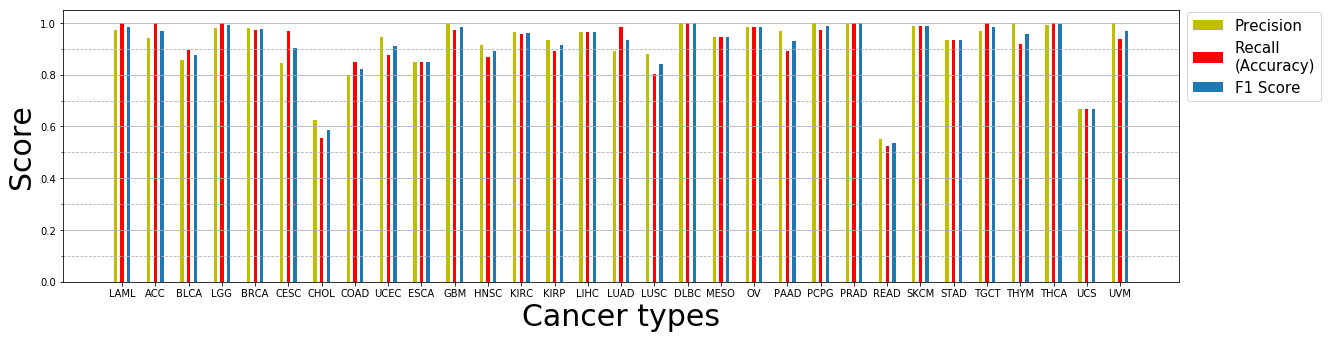

In [24]:
fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(0,len(precision))-0.2,precision,width=0.1,label = 'Precision',color='y')
plt.bar(np.arange(0,len(recall)),recall,width=0.1,label='Recall\n(Accuracy)',color='r')
plt.bar(np.arange(0,len(fscore))+0.2,fscore,width=0.1,label = 'F1 Score')
plt.ylabel('Score',fontsize=30)
plt.xlabel('Cancer types',fontsize=30)
plt.xticks(np.arange(0,len(precision)),label)
plt.legend(bbox_to_anchor=(1, 1.02),prop={'size':15})
ax = plt.axes()
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('BNN_results')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

# Uncertainty Calculation filter 1

C:\Users\Prasoon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


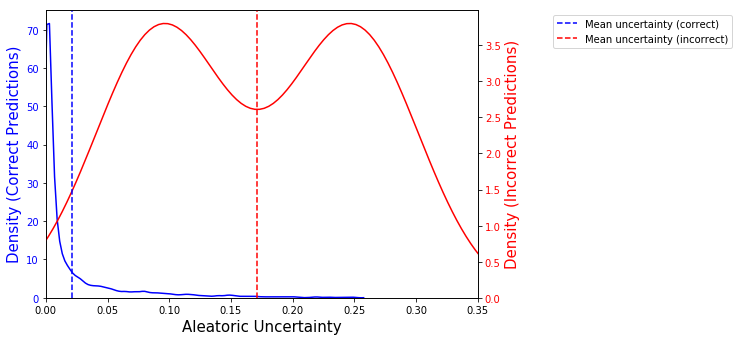

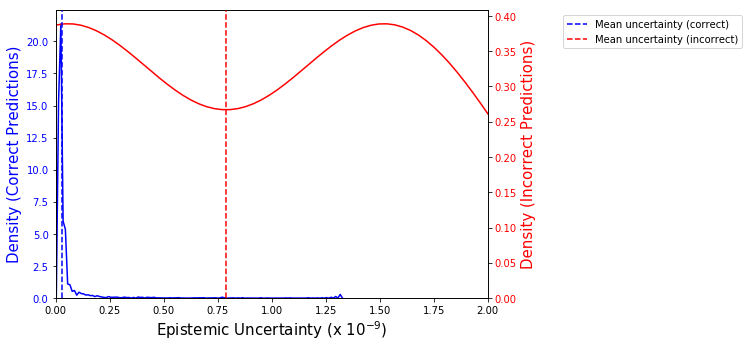

In [25]:
[al_train,mu_train_ac,mu_train_nac] = filter_1(logits_train,y_train,arr_pred_train,'Aleatoric','Train',_,'aleatoric_train')
[ep_train,mu_train_ec,mu_train_nec] = filter_1(logits_train,y_train,arr_pred_train,'Epistemic','Train',_,'epistemic_train')

C:\Users\Prasoon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


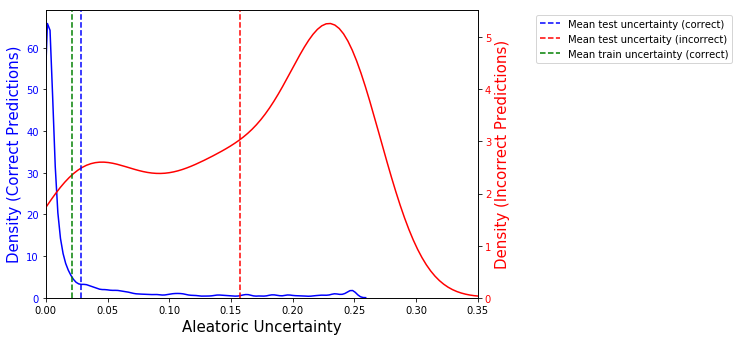

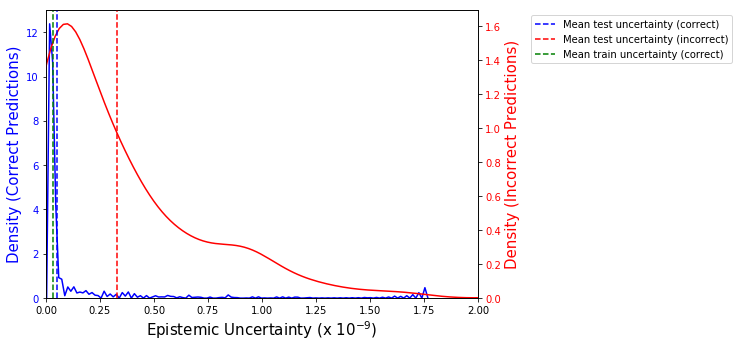

In [26]:
[al_test,mu_test_ac,mu_test_nac] = filter_1(logits,y_test,arr_pred_test,'Aleatoric','Test',mu_train_ac,'aleatoric_test')
[ep_test,mu_test_ec,mu_test_nec] = filter_1(logits,y_test,arr_pred_test,'Epistemic','Test',mu_train_ec,'epistemic_test')

# Results  filter 1

In [27]:
certain_pred = []
certain_test = []
for i in range(len(list(arr_pred_test))):
    if (ep_test[i] <= mu_train_ec) and (al_test[i] <= mu_train_ac):
        certain_pred.append(arr_pred_test[i])
        certain_test.append(np.array(y_test)[i])

In [28]:
precision = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[0]
recall = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[1]
fscore = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[2]
support = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[3]

# Saving results filter 1

In [29]:
df_temp = pd.DataFrame()
df_temp['precision'] = list(precision)
df_temp['recall'] = list(recall)
df_temp['fscore'] = list(fscore)
df_temp['support'] = list(support)
#df_temp.to_csv('Desktop/paper_tables/bnn_results_method1.csv')

In [30]:
label_new = []
for key in Counter(np.array(certain_test)).keys():
    label_new.append(label[key])

# Plotting results filter 1

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


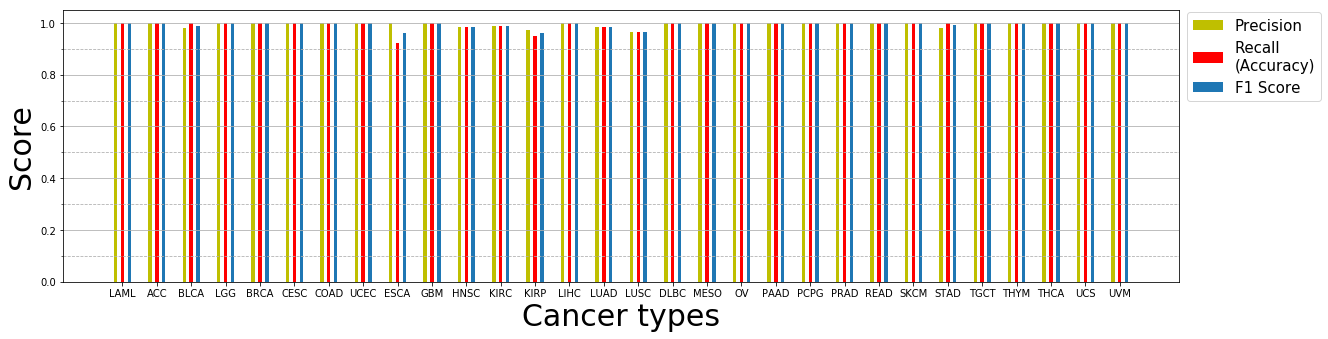

In [31]:
fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(0,len(precision))-0.2,precision,width=0.1,label = 'Precision',color='y')
plt.bar(np.arange(0,len(recall)),recall,width=0.1,label='Recall\n(Accuracy)',color='r')
plt.bar(np.arange(0,len(fscore))+0.2,fscore,width=0.1,label = 'F1 Score')
plt.ylabel('Score',fontsize=30)
plt.xlabel('Cancer types',fontsize=30)
plt.xticks(np.arange(0,len(precision)),label_new)
plt.legend(bbox_to_anchor=(1, 1.02),prop={'size':15})
ax = plt.axes()
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('train_uncertainty_filtering')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

# Uncertainty calculation filter 2

In [32]:
dict_numtrain_samples = Counter(np.array(y_train))
dict_numtest_samples = Counter(np.array(y_test))

In [33]:
dict_result_train = type_wise_results(dict_numtrain_samples,np.array(y_train),arr_pred_train,al_train,ep_train)
dict_result_test = type_wise_results(dict_numtest_samples,np.array(y_test),arr_pred_test,al_test,ep_test)

# Epistemic uncertainty filter 2

C:\Users\Prasoon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Prasoon\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


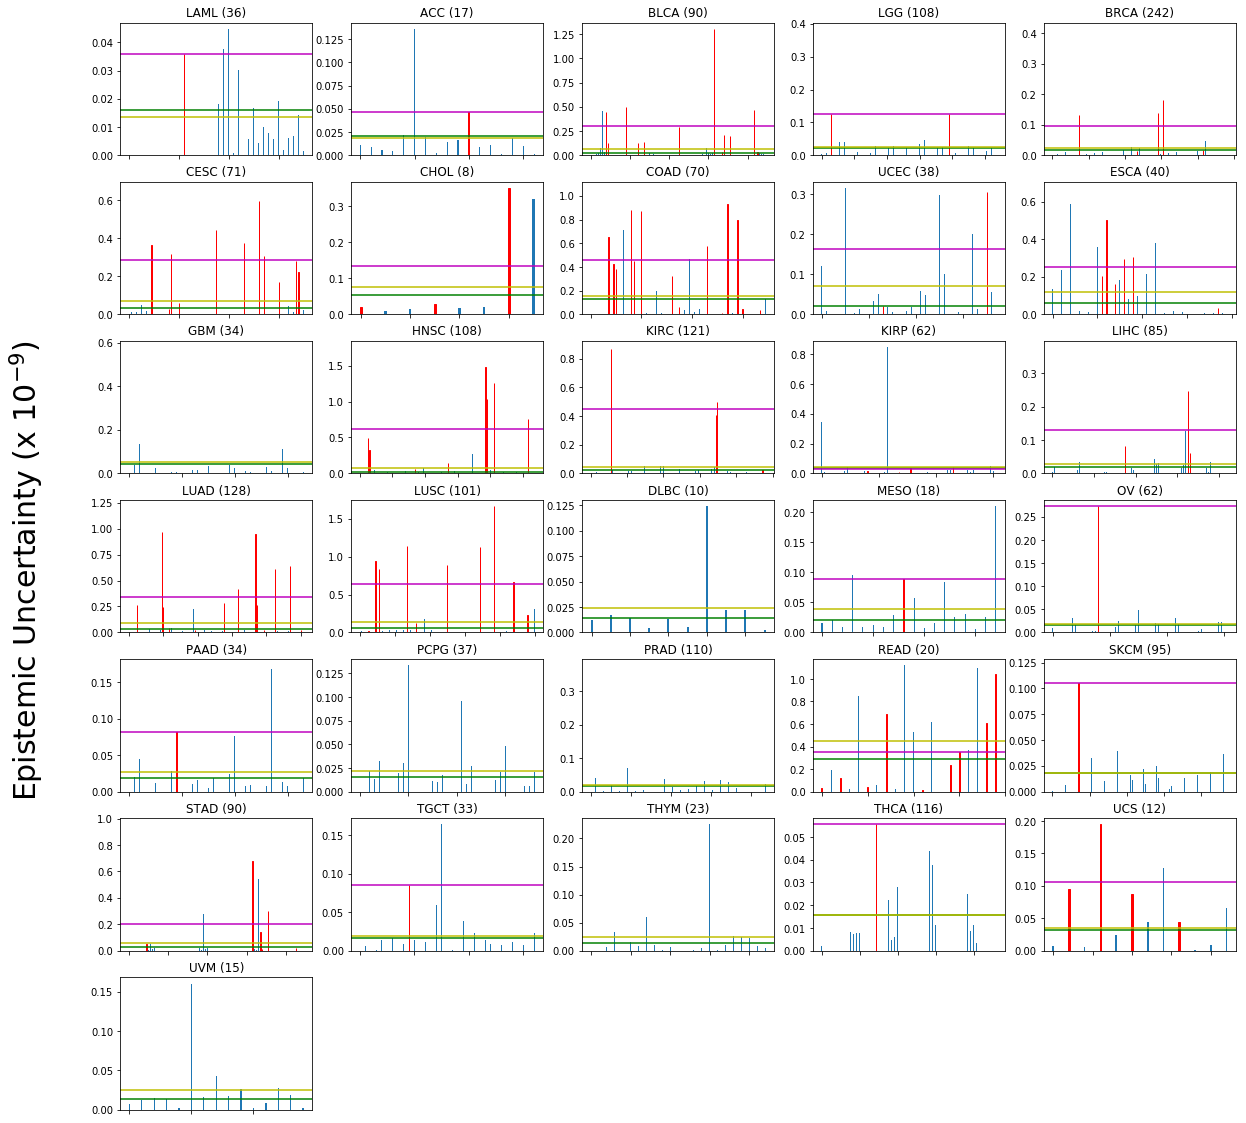

In [34]:
dict_mean_ep,dict_mean_test_corr,dict_mean_test_incorr = filter_2(dict_result_train,'Epistemic',np.array(y_test),arr_pred_test,ep_test,'epistemic_uncertainty_cancer_wise')

In [35]:
df_temp = pd.DataFrame()
df_temp['train_mean'] = list(dict_mean_ep.values())
df_temp['test_mean_correct'] = list(dict_mean_test_corr.values())
df_temp['test_mean_incorrect'] = list(dict_mean_test_incorr.values())
#df_temp.to_csv('Desktop/paper_tables/detailed_uncertainty_epistemic.csv')

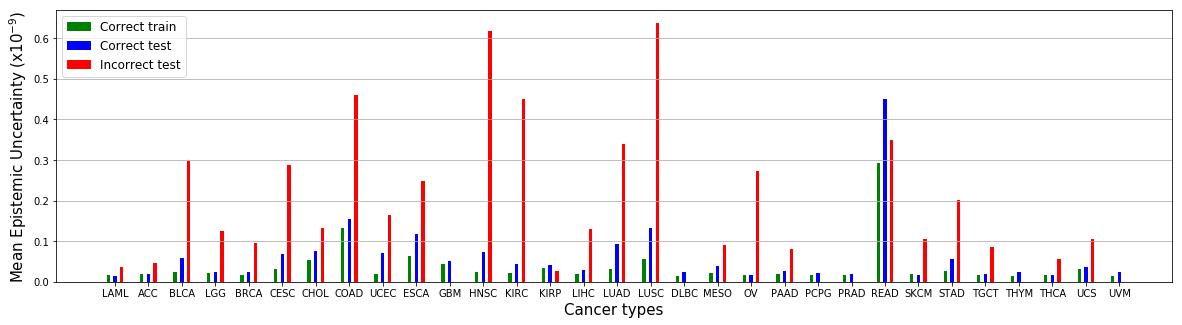

In [36]:
fig = plt.figure(figsize=(20,5))
for key in dict_mean_test_corr.keys():
    plt.bar(key-0.2,dict_mean_ep[key],width=0.1,color='green')
    plt.bar(key,dict_mean_test_corr[key],width=0.1,color='blue')
    plt.bar(key+0.2,dict_mean_test_incorr[key],width=0.1,color='red')
    if key == 30:
        plt.bar(key-0.2,dict_mean_ep[key],width=0.1,color='green',label='Correct train')
        plt.bar(key,dict_mean_test_corr[key],width=0.1,color='blue',label='Correct test')
        plt.bar(key+0.2,dict_mean_test_incorr[key],width=0.1,color='red',label = 'Incorrect test')
plt.ylabel('Mean Epistemic Uncertainty (x'+str(r'$10^{-9}$')+')',fontsize=15)
plt.xlabel('Cancer types',fontsize=15)
plt.xticks(np.arange(0,31),label)
plt.legend(prop={'size':12})
ax = plt.gca()
ax.yaxis.grid(True,which='major')
#ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('epistemic_uncertainty_results')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

# Aleatoric uncertainty filter 2

C:\Users\Prasoon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Prasoon\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:718: RuntimeWarning: invalid value encountered in less
  scaley = (yy < ymin) or (yy > ymax)
C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:718: RuntimeWarning: invalid value encountered in greater
  scaley = (yy < ymin) or (yy > ymax)


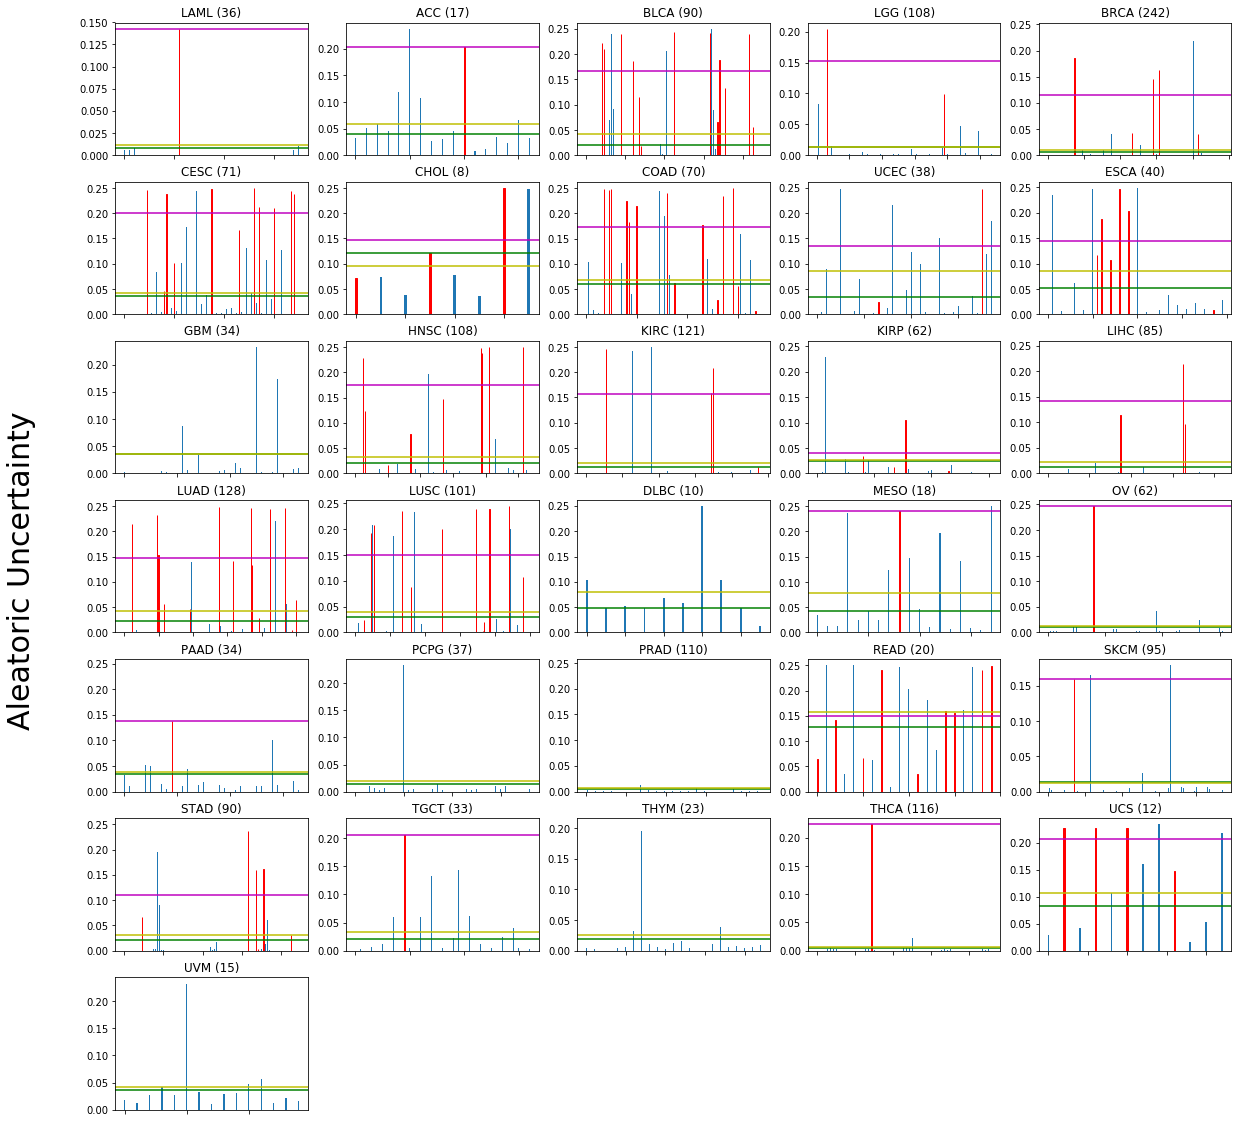

In [37]:
dict_mean_al,dict_mean_test_corr,dict_mean_test_incorr = filter_2(dict_result_train,'Aleatoric',np.array(y_test),arr_pred_test,al_test,'test1')

In [38]:
df_temp = pd.DataFrame()
df_temp['train_mean'] = list(dict_mean_al.values())
df_temp['test_mean_correct'] = list(dict_mean_test_corr.values())
df_temp['test_mean_incorrect'] = list(dict_mean_test_incorr.values())
#df_temp.to_csv('Desktop/paper_tables/detailed_uncertainty_aleatoric.csv')

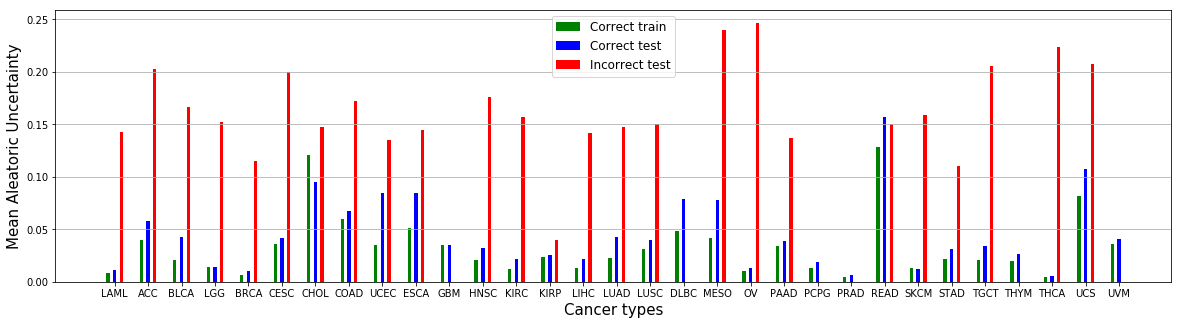

In [39]:
fig = plt.figure(figsize=(20,5))
for key in dict_mean_test_corr.keys():
    plt.bar(key-0.2,dict_mean_al[key],width=0.1,color='green')
    plt.bar(key,dict_mean_test_corr[key],width=0.1,color='blue')
    plt.bar(key+0.2,dict_mean_test_incorr[key],width=0.1,color='red')
    if key == 30:
        plt.bar(key-0.2,dict_mean_al[key],width=0.1,color='green',label='Correct train')
        plt.bar(key,dict_mean_test_corr[key],width=0.1,color='blue',label='Correct test')
        plt.bar(key+0.2,dict_mean_test_incorr[key],width=0.1,color='red',label = 'Incorrect test')
plt.ylabel('Mean Aleatoric Uncertainty',fontsize=15)
plt.xlabel('Cancer types',fontsize=15)
plt.xticks(np.arange(0,31),label)
plt.legend(prop={'size':12})
ax = plt.gca()
ax.yaxis.grid(True,which='major')
#ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('aleatoric_uncertainty_results')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

# Results filter 2

In [40]:
list_final_pred = []
list_final_test = []
for i in range(len(arr_pred_test)):
    if (al_test[i] <= dict_mean_al[arr_pred_test[i]]) and (ep_test[i]*1e9 <= dict_mean_ep[arr_pred_test[i]]):
        list_final_test.append(np.array(y_test)[i])
        list_final_pred.append(arr_pred_test[i])

In [41]:
precision = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[0]
recall = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[1]
fscore = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[2]
support = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[3]

In [42]:
df_temp = pd.DataFrame()
df_temp['precision'] = list(precision)
df_temp['recall'] = list(recall)
df_temp['fscore'] = list(fscore)
df_temp['support'] = list(support)
#df_temp.to_csv('Desktop/paper_tables/bnn_results_method2.csv')

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


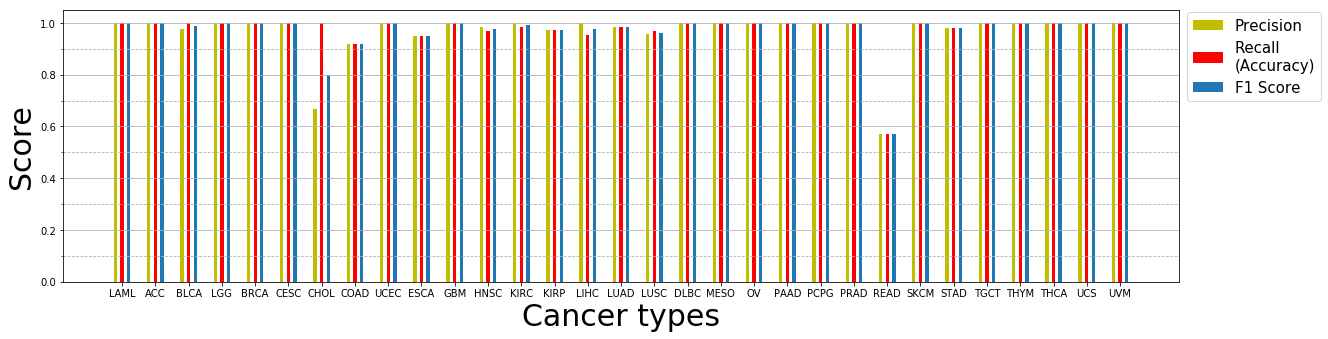

In [43]:
fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(0,len(precision))-0.2,precision,width=0.1,label = 'Precision',color='y')
plt.bar(np.arange(0,len(recall)),recall,width=0.1,label='Recall\n(Accuracy)',color='r')
#plt.plot(['1','2','3','4','5','6','7','8'],list_recall)
plt.bar(np.arange(0,len(fscore))+0.2,fscore,width=0.1,label = 'F1 Score')
plt.ylabel('Score',fontsize=30)
plt.xlabel('Cancer types',fontsize=30)
plt.xticks(np.arange(0,len(precision)),label)

plt.legend(bbox_to_anchor=(1, 1.02),prop={'size':15})
#plt.grid()
ax = plt.axes()
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
ax.yaxis.grid(True,which='minor',linestyle='--')
#fig.savefig('Desktop/paper_figures/'+str('cancer_type_uncertainty_filtering')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

# Accuracy as a function of filtering cut-off

In [44]:
acc_1= []
sam_1 = []
list_temp = np.arange(0.1,5.1,0.1)
for j in list_temp:
    certain_pred = []
    certain_test = []
    for i in range(len(list(arr_pred_test))):
        if (ep_test[i] <= j * mu_train_ec) and (al_test[i] <= j* mu_train_ac):
            certain_pred.append(arr_pred_test[i])
            certain_test.append(np.array(y_test)[i])
    acc_1.append(accuracy_score(certain_test,certain_pred))
    sam_1.append(len(certain_pred))

In [45]:
acc_2 = []
l_temp = np.arange(0.1,5.1,0.1)
sam_2 = []
for j in l_temp:
    list_final_pred = []
    list_final_test = []
    for i in range(len(arr_pred_test)):
        if (al_test[i] <= j* dict_mean_al[arr_pred_test[i]]) and (ep_test[i]*1e9 <= j* dict_mean_ep[arr_pred_test[i]]):
            list_final_test.append(np.array(y_test)[i])
            list_final_pred.append(arr_pred_test[i])
    acc_2.append(accuracy_score(list_final_test,list_final_pred))
    sam_2.append(len(list_final_test))

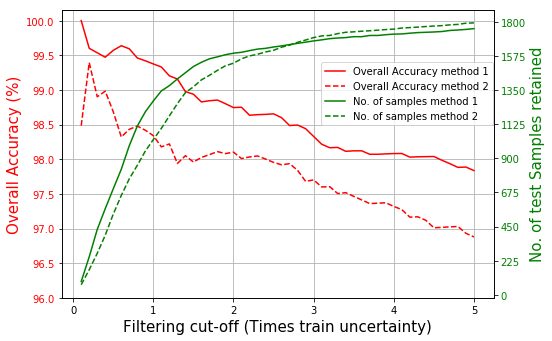

In [46]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax2 = ax1.twinx()
l1 = ax1.plot(l_temp,np.array(acc_2)*100,c='r',linestyle='--',label='Overall Accuracy filter 2')
l2 = ax1.plot(l_temp,np.array(acc_1)*100,c='r',label='Overall Accuracy filter 1')
ax1.tick_params(axis='y', labelcolor='r')
l3 = ax2.plot(l_temp,sam_2,c='g',linestyle = '--',label = 'No. of samples filter 2' )
l4 = ax2.plot(l_temp,sam_1,c='g',label='No. of samples filter 1')
ax2.tick_params(axis='y', labelcolor='g')
leg = l2+l1+l4+l3
ax1.set_ylabel('Overall Accuracy (%)', color='r',fontsize=15)
ax2.set_ylabel('No. of test Samples retained', color='g',fontsize=15)
ax1.set_xlabel('Filtering cut-off (Times train uncertainty)',fontsize=15)
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=(0.6,0.6))
ax2.set_yticks(np.arange(0,2000,225))
ax1.set_yticks(np.arange(0.96*100,1.005*100,0.005*100))
ax1.grid()
#fig.savefig('Desktop/paper_figures/'+str('times_train_uncertainty_plot')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

In [49]:
df_plot = pd.DataFrame()
df_plot['Cut-off'] = list(np.arange(0.1,5.1,0.1))
df_plot['Filter 1 Accuracy'] = list(np.array(acc_1) * 100)
df_plot['Filter 1 Samples'] = sam_1
df_plot['Filter 2 Accuracy'] = list(np.array(acc_2) * 100)
df_plot['Filter 2 Samples'] = sam_2

In [55]:
#df_plot.to_csv('D:/New folder/Table_of_Figures/3C.csv',index=False)

# Comparison plot

In [57]:
certain_pred = []
certain_test = []
for i in range(len(list(arr_pred_test))):
    if (ep_test[i] <= mu_train_ec) and (al_test[i] <= mu_train_ac):
        certain_pred.append(arr_pred_test[i])
        certain_test.append(np.array(y_test)[i])
list_final_pred = []
list_final_test = []
for i in range(len(arr_pred_test)):
    if (al_test[i] <= dict_mean_al[arr_pred_test[i]]) and (ep_test[i]*1e9 <= dict_mean_ep[arr_pred_test[i]]):
        list_final_test.append(np.array(y_test)[i])
        list_final_pred.append(arr_pred_test[i])

In [58]:
fscore_1 = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[2]
fscore_2 = precision_recall_fscore_support(np.array(certain_test),np.array(certain_pred))[2]
fscore_3 = precision_recall_fscore_support(np.array(list_final_test),np.array(list_final_pred))[2]

In [59]:
label_new_adjusted = []
fscore_adjusted = []
for i in range(31):
    if i == 6:
        fscore_adjusted.append(0)
        label_new_adjusted.append('CHOL')
    if i>6:
        fscore_adjusted.append(fscore_2[i-1])
        label_new_adjusted.append(label_new[i-1])
    if i<6:
        fscore_adjusted.append(fscore_2[i])
        label_new_adjusted.append(label_new[i])

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


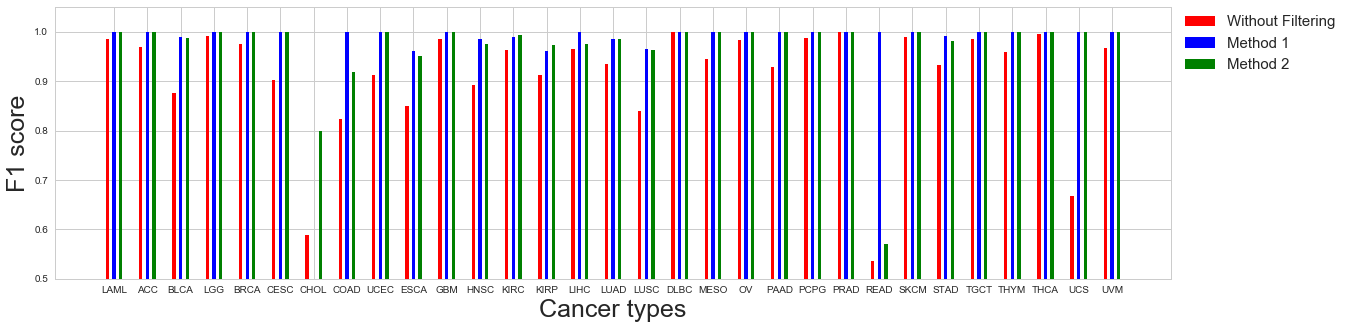

In [61]:
fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(0,len(fscore_1))-0.2,fscore_1,label = 'Without Filtering',color='r',width=0.1)
plt.bar(np.arange(0,len(fscore_adjusted)),np.array(fscore_adjusted),label='filter 1',color='b',width=0.1)
plt.bar(np.arange(0,len(fscore_3))+0.2,fscore_3,label = 'filter 2',color='g',width=0.1)
plt.ylabel('F1 score',fontsize=25)
plt.xlabel('Cancer types',fontsize=25)
plt.xticks(np.arange(0,len(precision)),label)
plt.ylim((0.5,1.05))
plt.legend(bbox_to_anchor=(1, 1.02),prop={'size':15})
ax = plt.axes()
ax.yaxis.grid(True,which='major')
fig.savefig('Desktop/paper_figures/'+str('criteria_comparison')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

# External Validation for cancer types

In [54]:
np.random.seed(0)
r = np.random.randint(500)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)

In [55]:
df_test = pd.read_csv('Desktop/combined_external.csv')

In [56]:
df_test = df_test[df_test['label'] == 4] 

In [57]:
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [58]:
Ytrain = np.array(y_train).reshape(len(y_train),)
X_train = np.array(X_train.T.reset_index(drop=True))
Y_train = tf.Session().run(tf.one_hot(Ytrain,len(set(Ytrain)),axis=1)).reshape(len(Ytrain),len(set(Ytrain))).T
Ytest = np.array(y_test).reshape(len(y_test),)
X_test = np.array(X_test.T.reset_index(drop=True))
Y_test = tf.Session().run(tf.one_hot(Ytest,len(set(Ytest)),axis=1)).reshape(len(Ytest),len(set(Ytest))).T

In [59]:
layers_dims = [X_train.shape[0],250,95,31]
[_,_,logits,logits_train,arr_pred_test,arr_pred_train] = model(X_train=X_train,Y_train=Y_train,X_test =X_test,Y_test = Y_test, learning_rate=0.0005,num_epochs=3500,print_cost=True,layers_dims = layers_dims)

Cost after epoch 0: 100.214638
Cost after epoch 100: 98.668396
Cost after epoch 200: 97.784966
Cost after epoch 300: 97.394218
Cost after epoch 400: 97.209717
Cost after epoch 500: 97.043793
Cost after epoch 600: 96.973923
Cost after epoch 700: 96.903824
Cost after epoch 800: 96.873451
Cost after epoch 900: 94.251862
Cost after epoch 1000: 94.231339
Cost after epoch 1100: 94.145981
Cost after epoch 1200: 94.149834
Cost after epoch 1300: 94.132957
Cost after epoch 1400: 94.144089
Cost after epoch 1500: 94.114418
Cost after epoch 1600: 92.242096
Cost after epoch 1700: 92.206703
Cost after epoch 1800: 92.249779
Cost after epoch 1900: 92.191315
Cost after epoch 2000: 92.212646
Cost after epoch 2100: 90.734207
Cost after epoch 2200: 90.751938
Cost after epoch 2300: 90.727829
Cost after epoch 2400: 90.691910
Cost after epoch 2500: 89.541817
Cost after epoch 2600: 89.578423
Cost after epoch 2700: 89.524017
Cost after epoch 2800: 88.507179
Cost after epoch 2900: 88.540108
Cost after epoch 3000

C:\Users\Prasoon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


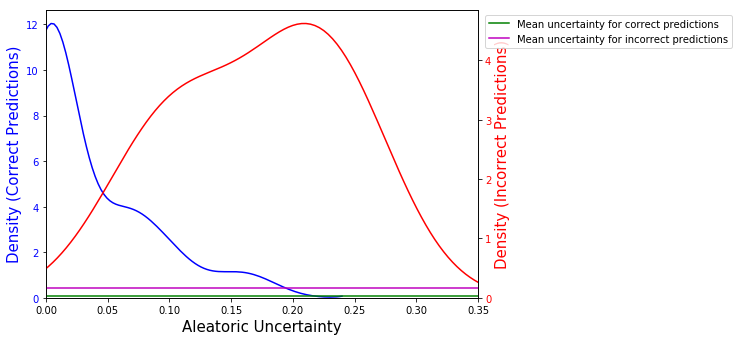

In [61]:
[al_val,mu_val_ac,mu_val_nac] = filter_1(logits,y_test,arr_pred_test,'Aleatoric','Validation',_,'validation_uncertainty')

C:\Users\Prasoon\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


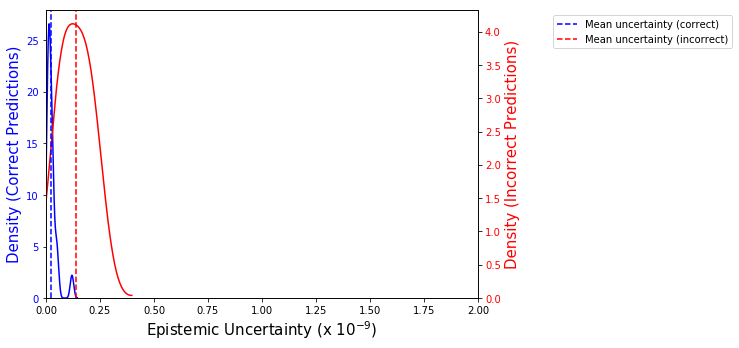

In [62]:
[ep_val,mu_val_ec,mu_val_nec] = filter_1(logits,y_test,arr_pred_test,'Epistemic','Train',_,'temp')

In [63]:
list_final_pred_val = []
list_final_test_val = []
for i in range(len(arr_pred_test)):
    if (al_val[i] <= dict_mean_al[arr_pred_test[i]]) and (ep_val[i]*1e9 <= dict_mean_ep[arr_pred_test[i]]):
        list_final_test_val.append(np.array(y_test)[i])
        list_final_pred_val.append(arr_pred_test[i])

In [64]:
certain_pred_val = []
certain_test_val = []
for i in range(len(list(arr_pred_test))):
    if (ep_val[i] <= mu_train_ec) and (al_val[i] <= mu_train_ac):
        certain_pred_val.append(arr_pred_test[i])
        certain_test_val.append(np.array(y_test)[i])

# Logistic Regression External  Validation

In [58]:
np.random.seed(0)
r = np.random.randint(500)
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)
df_test = pd.read_csv('Desktop/combined_external.csv')
df_test = df_test[df_test['label'] == 4] 
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]

In [59]:
clf_log = LogisticRegression(penalty='l2',C=1.0).fit(X_train,y_train)
clf_log.score(X_test,y_test)

0.76

# Cancer vs non-cancer

In [68]:
np.random.seed(0)
r = np.random.randint(500)

In [69]:
df_pca2 = pd.read_csv('D:/New folder/100_genes_pca2_new.csv')
(X_train, X_test, y_train, y_test) = split_train_test(df_pca2,r)
y_train_cancer = []
y_test_cancer = []
for j in range(len(X_train)):
    y_train_cancer.append(1)
for j in range(len(X_test)):
    y_test_cancer.append(1)
X_train.drop('C19orf46',axis=1,inplace=True)
X_train.drop('MOSC2',axis=1,inplace=True)
X_train.drop('LASS3',axis=1,inplace=True)
X_train.drop('TARP',axis=1,inplace=True)
X_train.drop('GOLGA2B',axis=1,inplace=True)
X_train.drop('EFCAB4A',axis=1,inplace=True)
X_train.drop('RTDR1',axis=1,inplace=True)
X_test.drop('C19orf46',axis=1,inplace=True)
X_test.drop('MOSC2',axis=1,inplace=True)
X_test.drop('LASS3',axis=1,inplace=True)
X_test.drop('TARP',axis=1,inplace=True)
X_test.drop('GOLGA2B',axis=1,inplace=True)
X_test.drop('EFCAB4A',axis=1,inplace=True)
X_test.drop('RTDR1',axis=1,inplace=True)
df_normal = pd.read_csv('Desktop/normal_data_new.csv')
df_normal['label'] = 0
(X_train_normal, X_test_normal, y_train_normal, y_test_normal) = train_test_split(df_normal.iloc[:,:-1],df_normal.iloc[:,-1], test_size=0.20, random_state=r)
y_train_normal = list(y_train_normal)
y_test_normal = list(y_test_normal)
y_train_cancer.extend(y_train_normal)
y_test_cancer.extend(y_test_normal)
y_train_combined =  np.array(y_train_cancer)
y_test_combined =  np.array(y_test_cancer)
X_train_combined = pd.concat([X_train, X_train_normal])
X_test_combined = pd.concat([X_test,X_test_normal])
clf_log = LogisticRegression(solver='lbfgs').fit(X_train_combined,y_train_combined)
clf_log.score(X_test_combined,y_test_combined)

1.0

# Confusion Matrix test

In [20]:
list_normalized = []
df_confusion = confusion_matrix(y_test,arr_pred_test)
df_confusion_normalized = ((df_confusion.T/df_confusion.sum(axis=1)).T) 
df_confusion_normalized = pd.DataFrame(df_confusion_normalized)
df_confusion_normalized.columns = label
df_confusion_normalized.index = label

In [21]:
#df_confusion_normalized.to_csv('D:/New Folder/Table_of_Figures/1C.csv')

In [21]:
#df_confusion_normalized.to_csv('Desktop/confusion_matrix_new.csv')

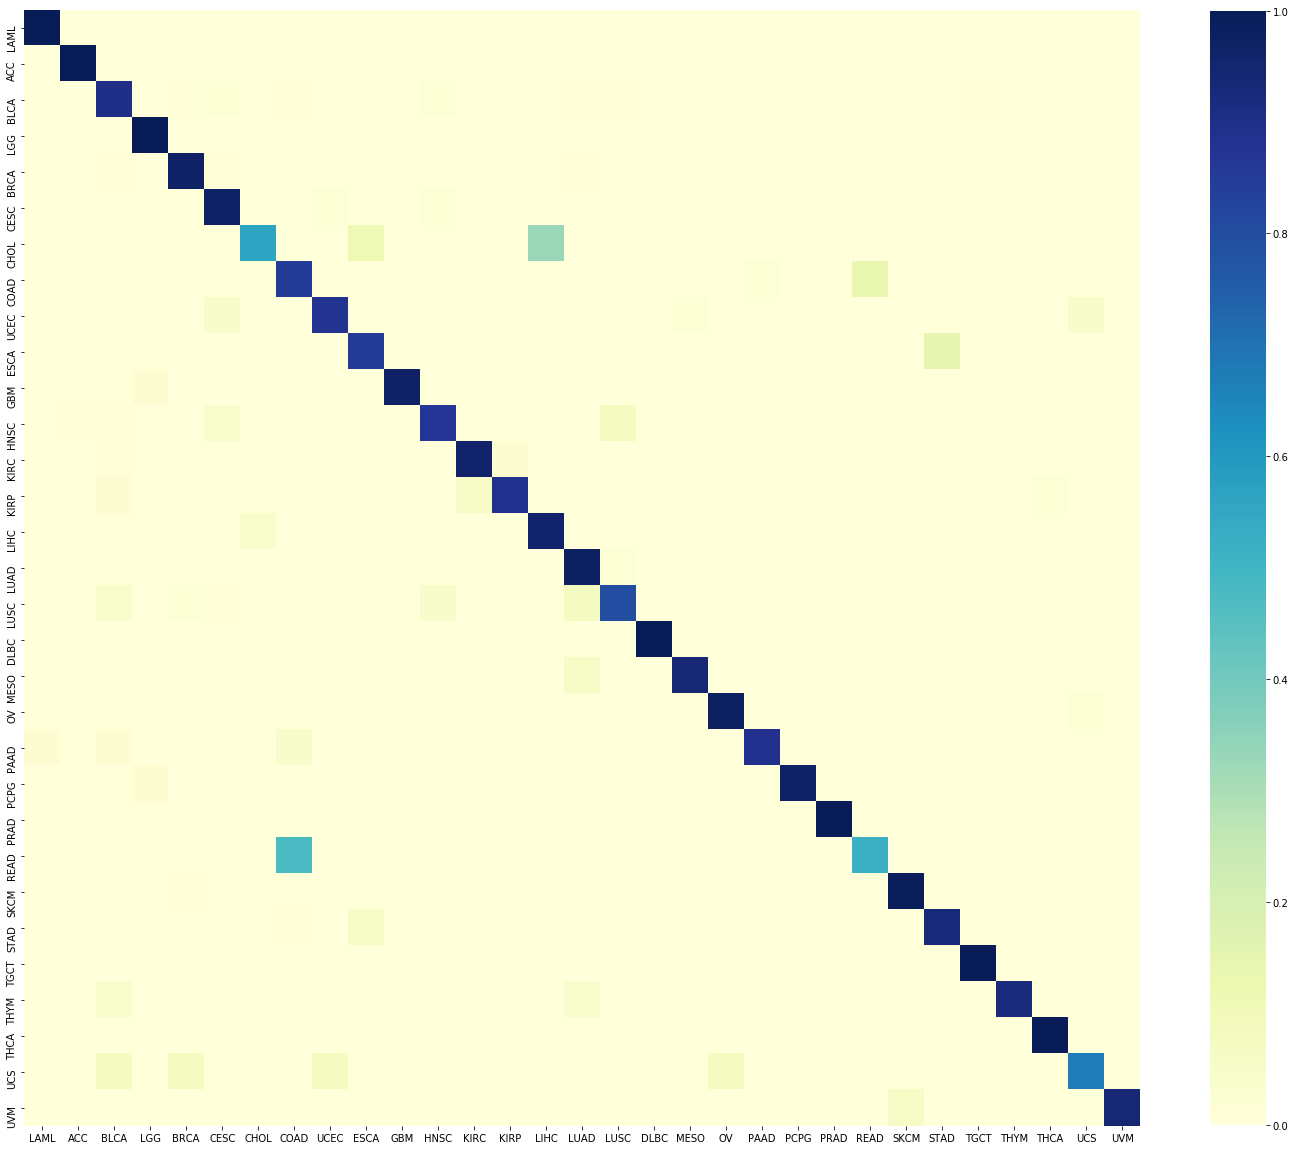

In [22]:
fig = plt.figure(figsize=(25,25))
sns.heatmap(df_confusion_normalized.round(2),cmap="YlGnBu",square=True,cbar_kws={"shrink": 0.82})
fig.savefig('Desktop/paper_figures/'+str('confusion_matrix')+'.pdf', format='pdf', dpi=600,bbox_inches='tight')

# Gene Wise Accuracy

In [20]:
np.random.seed(0)
r = np.random.randint(500)

In [21]:
train_accuracy_list = []
test_accuracy_list = []
logits_list = []
arr_pred_test_list = []
y_test_list = []
y_train_list = []
for i in range(len(df_pca2.columns)-1):
    df  = df_pca2.iloc[:,i:i+1]
    df['label'] = list(df_pca2.iloc[:,-1])
    X_train, X_test, y_train, y_test = split_train_test(df,r)
    clf_log = LogisticRegression().fit(X_train,y_train)
    train_accuracy = clf_log.score(X_train,y_train)
    test_accuracy = clf_log.score(X_test,y_test)
    arr_pred_test = clf_log.predict(X_test)
    logits = clf_log.predict_proba(X_test)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    logits_list.append(logits)
    arr_pred_test_list.append(arr_pred_test)
    y_test_list.append(y_test)
    y_train_list.append(y_train)
    print(i)
    print(train_accuracy)
    print(test_accuracy)

0
0.19754616433263106
0.19862340216322516
1
0.18998636757962573
0.18534906588003933
2
0.1994051307473045
0.19960668633235004
3
0.17052918577271037
0.17158308751229107
4
0.1986615441814351
0.18928220255653885
5
0.18688809022183667
0.18682399213372664
6
0.18787953897632917
0.1848574237954769
7
0.17090097905564505
0.17010816125860373
8
0.16730697732060973
0.16666666666666666
9
0.2070888585946214
0.21140609636184857
10
0.18986243648531417
0.18977384464110128
11
0.12888833808402528
0.12536873156342182
12
0.13037551121576405
0.12831858407079647
13
0.1304994423100756
0.12340216322517207
14
0.13570454827116124
0.1302851524090462
15
0.14140537860949312
0.13864306784660768
16
0.13124302887594497
0.12733529990167158
17
0.12764902714090964
0.12192723697148476
18
0.13458916842235716
0.13176007866273354
19
0.13620027264840748
0.13176007866273354
20
0.14561903581608626
0.14060963618485742
21
0.1328541331019953
0.12586037364798427
22
0.13334985747924155
0.13225172074729596
23
0.13967034328913125
0.145

# Extension of Single Gene Analysis

In [22]:
dict_genes = {}
for i in range(len(list(df_pca2.columns))):
    dict_genes[i] = list(df_pca2.columns)[i]

In [23]:
dict_list = {}
for i in range(len(y_test_list)):
    fscore = precision_recall_fscore_support(np.array(y_test_list[i]),np.array(arr_pred_test_list[i]))[2]
    for j in range(31):
        try:
            dict_list[j].append(fscore[j])
        except:
            dict_list[j] = [fscore[j]]

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
num_cancer_types = []
genes_for_entire_analysis = []
for num_gene in range(1,21):
    print(num_gene)
    list_fscore = []
    list_precision = []
    list_recall = []
    list_all_genes = []
    
    for i in range(31):
        #print(i)
        if num_gene == 103:
            top_five_genes = list((-1*np.array(dict_list[i])).argsort())[0:num_gene]
        else:
            temp = list(np.array(dict_list[i]))
            num_non_zero = len([x for x in temp if x != 0])
            if (num_non_zero < num_gene):
                top_five_genes = list((-1*np.array(dict_list[i])).argsort())[0:num_non_zero]
            else:
                top_five_genes = list((-1*np.array(dict_list[i])).argsort())[0:num_gene]


        if len(top_five_genes) > 0:
            list_genes = []
            for j in range(len(top_five_genes)):
                list_genes.append(dict_genes[top_five_genes[j]])
            list_all_genes.append(list_genes)
            list_genes.append('label')
            df_temp = df_pca2[list_genes]
            X_train, X_test, y_train, y_test = split_train_test(df_temp,r)
            clf_log = LogisticRegression(penalty='l2',C=1.0).fit(X_train,y_train)
            arr_pred_test = clf_log.predict(X_test)
            precision = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[0]
            recall = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[1]
            fscore = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[2]
            list_precision.append(precision[i])
            list_recall.append(recall[i])
            list_fscore.append(fscore[i])   
        else:
            list_all_genes.append(0)
            list_precision.append(0)
            list_recall.append(0)
            list_fscore.append(0)
            
    genes_for_entire_analysis.append(list_all_genes)

    cancer_type = []
    genes_final = []
    
    for z in range(31):
        if ((list_precision[z] >= 0.75) and (list_recall[z] >= 0.75)):
            cancer_type.append(z)
            genes_final.append(list_all_genes[z])
    
    heterogenous = []
    if num_gene == 20:
        for cluster in range(31):
            if (cluster in cancer_type) == False:
                heterogenous.append(cluster)
            
    num_cancer_types.append(len(genes_final))
    print(num_cancer_types)
    print(cancer_type)

1
[2]
[0, 22]
2
[2, 4]
[0, 3, 22, 28]
3
[2, 4, 6]
[0, 3, 12, 14, 22, 28]
4
[2, 4, 6, 6]
[0, 3, 12, 14, 22, 28]
5
[2, 4, 6, 6, 7]
[0, 3, 4, 12, 14, 22, 28]
6
[2, 4, 6, 6, 7, 8]
[0, 3, 4, 12, 13, 14, 22, 28]
7
[2, 4, 6, 6, 7, 8, 8]
[0, 3, 4, 12, 13, 14, 22, 28]
8
[2, 4, 6, 6, 7, 8, 8, 8]
[0, 3, 4, 12, 13, 14, 22, 28]
9
[2, 4, 6, 6, 7, 8, 8, 8, 8]
[0, 3, 4, 12, 13, 14, 22, 28]
10
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8]
[0, 3, 4, 12, 13, 14, 22, 28]
11
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9]
[0, 3, 4, 12, 13, 14, 22, 25, 28]
12
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10]
[0, 3, 4, 12, 13, 14, 22, 24, 25, 28]
13
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10]
[0, 3, 4, 12, 13, 14, 22, 24, 25, 28]
14
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10]
[0, 3, 4, 12, 13, 14, 22, 24, 25, 28]
15
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10]
[0, 3, 4, 12, 13, 14, 22, 24, 25, 28]
16
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10]
[0, 3, 4, 12, 13, 14, 22, 24, 25, 28]
17
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 

In [81]:
genes_for_entire_analysis[11][24]

['CABLES1',
 'TBC1D16',
 'PLOD3',
 'VIPR1',
 'SLC4A2',
 'GOLGA2B',
 'PTPN23',
 'PLCH2',
 'RAI1',
 'HGD',
 'SRP9',
 'GJA1',
 'label']

In [82]:
label[24]

'SKCM'

In [27]:
num_cancer_types = []
for num_gene in range(1,104):
    print(num_gene)
    list_fscore = []
    list_precision = []
    list_recall = []
    list_all_genes = []
    for i in range(31):
        #print(i)
        temp = list(np.array(dict_list[i]))
        num_non_zero = len([x for x in temp if x != 0])
        if (num_non_zero < num_gene):
            top_five_genes = list((-1*np.array(dict_list[i])).argsort())[0:num_non_zero]
        else:
            top_five_genes = list((-1*np.array(dict_list[i])).argsort())[0:num_gene]


        if len(top_five_genes) > 0:
            list_genes = []
            for j in range(len(top_five_genes)):
                list_genes.append(dict_genes[top_five_genes[j]])
            list_all_genes.append(list_genes)
            list_genes.append('label')
            df_temp = df_pca2[list_genes]
            X_train, X_test, y_train, y_test = split_train_test(df_temp,r)
            clf_log = LogisticRegression(penalty='l2',C=1.0).fit(X_train,y_train)
            arr_pred_test = clf_log.predict(X_test)
            precision = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[0]
            recall = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[1]
            fscore = precision_recall_fscore_support(np.array(y_test),np.array(arr_pred_test))[2]
            list_precision.append(precision[i])
            list_recall.append(recall[i])
            list_fscore.append(fscore[i])   
        else:
            list_all_genes.append(0)
            list_precision.append(0)
            list_recall.append(0)
            list_fscore.append(0)
            
    cancer_type = []
    genes_final = []
    
    for z in range(31):
        if ((list_precision[z] >= 0.75) and (list_recall[z] >= 0.75)):
            cancer_type.append(z)
            genes_final.append(list_all_genes[z])
    
    heterogenous = []
    if num_gene == 20:
        for cluster in range(31):
            if (cluster in cancer_type) == False:
                heterogenous.append(cluster)
            
    num_cancer_types.append(len(genes_final))
    print(num_cancer_types)
    print(cancer_type)

1
[2]
[0, 22]
2
[2, 4]
[0, 3, 22, 28]
3
[2, 4, 6]
[0, 3, 12, 14, 22, 28]
4
[2, 4, 6, 6]
[0, 3, 12, 14, 22, 28]
5
[2, 4, 6, 6, 7]
[0, 3, 4, 12, 14, 22, 28]
6
[2, 4, 6, 6, 7, 8]
[0, 3, 4, 12, 13, 14, 22, 28]
7
[2, 4, 6, 6, 7, 8, 8]
[0, 3, 4, 12, 13, 14, 22, 28]
8
[2, 4, 6, 6, 7, 8, 8, 8]
[0, 3, 4, 12, 13, 14, 22, 28]
9
[2, 4, 6, 6, 7, 8, 8, 8, 8]
[0, 3, 4, 12, 13, 14, 22, 28]
10
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8]
[0, 3, 4, 12, 13, 14, 22, 28]
11
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9]
[0, 3, 4, 12, 13, 14, 22, 25, 28]
12
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10]
[0, 3, 4, 12, 13, 14, 22, 24, 25, 28]
13
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10]
[0, 3, 4, 12, 13, 14, 22, 24, 25, 28]
14
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10]
[0, 3, 4, 12, 13, 14, 22, 24, 25, 28]
15
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10]
[0, 3, 4, 12, 13, 14, 22, 24, 25, 28]
16
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10]
[0, 3, 4, 12, 13, 14, 22, 24, 25, 28]
17
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 

[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[0, 3, 4, 11, 12, 13, 14, 22, 24, 25, 28]
59
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[0, 3, 4, 11, 12, 13, 14, 22, 24, 25, 28]
60
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[0, 3, 4, 11, 12, 13, 14, 22, 24, 25, 28]
61
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1

[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[0, 3, 4, 11, 12, 13, 14, 22, 24, 25, 28]
85
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[0, 3, 4, 11, 12, 13, 14, 22, 24, 25, 28]
86
[2, 4, 6, 6, 7, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 

In [49]:
len(list_all_genes)

31

In [27]:
heterogenous

[6, 9, 23, 29]

In [28]:
heterogenous

[1, 2, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 23, 26, 27, 29, 30]

In [28]:
genes_final

[['TMEM54', 'label'], ['TARP', 'label']]

In [32]:
label[6]

'CHOL'

In [33]:
label[29]

'UCS'

In [34]:
label[23]

'READ'

In [35]:
label[9]

'ESCA'

In [141]:
#sns.set_style('whitegrid')

In [33]:
sns.set_style('whitegrid')

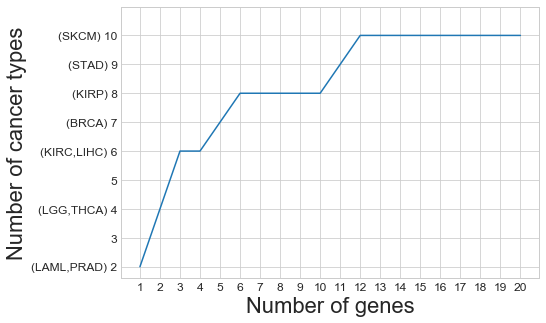

In [55]:
fig, ax = plt.subplots(figsize=(7.5,5)) 
xticks = np.array(['(LAML,PRAD) 2','3','(LGG,THCA) 4','5','(KIRC,LIHC) 6','(BRCA) 7','(KIRP) 8','(STAD) 9','(SKCM) 10'])
ax.plot(np.arange(1,21),num_cancer_types)
ax.set_xticks(np.arange(1,21))
ax.set_yticks(np.arange(2,12,1))
ax.set_yticklabels(xticks)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Number of genes',fontsize=22)
plt.ylabel('Number of cancer types',fontsize=22)
fig.savefig('Desktop/paper_figures/'+str('No. of genes plot')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')

In [128]:
cancer_type = []
genes_final = []
for i in range(31):
    if ((list_precision[i] >= 0.75) and (list_recall[i] >= 0.75)):
        cancer_type.append(i)
        genes_final.append(list_all_genes[i])

In [129]:
genes_final

[['TMEM54', 'PARVA', 'PCGF2', 'ANTXR1', 'MYO1F', 'label'],
 ['ATP1B2', 'ATP6V1G2', 'ZDHHC12', 'NAP1L3', 'ABI2', 'label'],
 ['DEFB132', 'CREB3L4', 'GDA', 'SIDT1', 'KLHL38', 'label'],
 ['PAX8', 'BHMT2', 'FASN', 'RTDR1', 'KCNJ16', 'label'],
 ['MOSC2', 'HGD', 'DDR1', 'DNAJC18', 'RAI1', 'label'],
 ['TARP', 'VIPR1', 'C19orf46', 'STMN1', 'DEFB132', 'label'],
 ['FOXE1', 'PAX8', 'KCNJ16', 'KIAA1211', 'SGMS2', 'label']]

In [130]:
cancer_type

[0, 3, 4, 12, 14, 22, 28]

In [165]:
list_fscore[28]

0.9465020576131687

In [157]:
label[28]

'THCA'

In [114]:
b.append(a)

In [115]:
b

[5, 6, [2]]

In [116]:
a

[2]

In [ ]:
dict

In [ ]:
fscore = precision_recall_fscore_support(np.array(y_test_list[2]),np.array(arr_pred_test_list[2]))

In [64]:
len(fscore)

4

In [53]:
Counter(arr_pred_test_list[8])

Counter({4: 1463, 25: 273, 15: 266, 12: 14, 7: 18})

In [ ]:
precision_recall_f

In [54]:
Counter(y_test_list[0])

Counter({0: 35,
         1: 16,
         2: 86,
         3: 106,
         4: 244,
         5: 62,
         6: 9,
         7: 66,
         8: 41,
         9: 40,
         10: 35,
         11: 114,
         12: 122,
         13: 65,
         14: 85,
         15: 116,
         16: 111,
         17: 10,
         18: 18,
         19: 62,
         20: 37,
         21: 38,
         22: 110,
         23: 21,
         24: 95,
         25: 90,
         26: 32,
         27: 25,
         28: 115,
         29: 12,
         30: 16})

In [55]:
len(y_test_list)

103

# Single Gene Analysis contd

In [22]:
dict_report = {}
for i in range(len(y_test_list)):
    matrix_temp = confusion_matrix(y_test_list[i], arr_pred_test_list[i])
    accuracy_temp = matrix_temp.diagonal()/matrix_temp.sum(axis=1)
    indices = list(np.where(accuracy_temp >= 0.75)[0])
    if len(indices) > 0:
        accuracy = accuracy_temp[indices]
        precision = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[0][indices]
        recall = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[1][indices]
        fscore = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[2][indices]
        dict_report[i] = [indices,accuracy,precision,recall,fscore]

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

In [23]:
dict_report_refined = {}
for key in dict_report.keys():
    report_index = dict_report[key][0]
    report_accuracy = dict_report[key][1]
    report_precision = dict_report[key][2]
    report_recall = dict_report[key][3]
    report_score = dict_report[key][4]
    list_index = []
    list_accuracy = []
    list_precision = []
    list_recall = []
    list_score = []
    for i in range(len(report_index)):
        if (report_precision[i] >= 0.75):
            list_index.append(report_index[i])
            list_accuracy.append(report_accuracy[i])
            list_precision.append(report_precision[i])
            list_recall.append(report_recall[i])
            list_score.append(report_score[i])
    if (len(list_index)>0):
        dict_report_refined[key] = [list_index,list_accuracy,list_precision,list_recall,list_score]

In [24]:
a = list(dict_report_refined.keys())
gene_list = []
for i in range(len(a)):
    gene = df_pca2.columns[a[i]]
    gene_list.append(gene)
l_str_label = []
for key in dict_report_refined.keys():
    index = dict_report_refined[key][0][0]
    str_label = label[index]
    l_str_label.append(str_label)
l_str_new = []
for i in range(len(gene_list)):
    str_new = gene_list[i]+'\n'+'('+l_str_label[i]+')'
    l_str_new.append(str_new)

In [25]:
list_index = []
list_accuracy = []
list_precision = []
list_recall = []
list_fscore = []
for key in dict_report_refined.keys():
    index = dict_report_refined[key][0][0]
    accuracy = dict_report_refined[key][1][0]
    precision = dict_report_refined[key][2][0]
    recall = dict_report_refined[key][3][0]
    fscore = dict_report_refined[key][4][0]
    list_index.append(index)
    list_accuracy.append(accuracy)
    list_precision.append(precision)
    list_recall.append(recall)
    list_fscore.append(fscore)

C:\Users\Prasoon\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


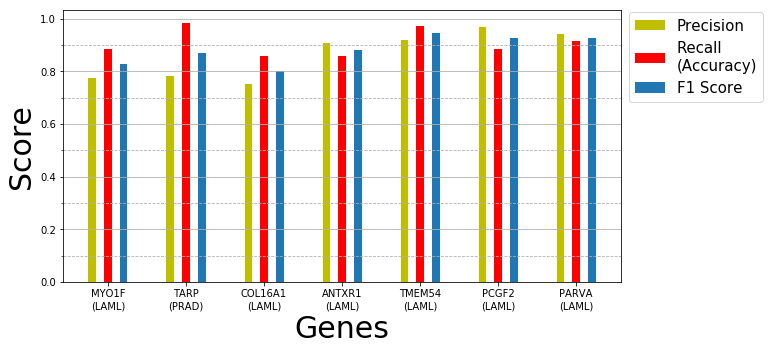

In [26]:
fig = plt.figure(figsize=(10,5))
plt.bar(np.arange(0,len(list_precision))-0.2,list_precision,width=0.1,label = 'Precision',color='y')
plt.bar(np.arange(0,len(list_recall)),list_recall,width=0.1,label='Recall\n(Accuracy)',color='r')
plt.bar(np.arange(0,len(list_fscore))+0.2,list_fscore,width=0.1,label = 'F1 Score')
plt.ylabel('Score',fontsize=30)
plt.xlabel('Genes',fontsize=30)
plt.xticks(np.arange(0,len(l_str_new)),l_str_new)

plt.legend(bbox_to_anchor=(1, 1.02),fontsize=15)
ax = plt.axes()
ax.set_yticks([0.1,0.3,0.5,0.7,0.9], minor=True)
ax.yaxis.grid(True,which='major')
ax.yaxis.grid(True,which='minor',linestyle='--')
plt.show()
#fig.savefig('Desktop/paper_figures/'+str('gene_wise_accuracy')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')

In [27]:
df_precision = pd.DataFrame(data = 0, index = list(df_pca2.columns[:-1]),columns = np.arange(0,len(set(y_test_list[0]))))
df_recall = pd.DataFrame(data = 0, index = list(df_pca2.columns[:-1]),columns = np.arange(0,len(set(y_test_list[0]))))
df_fscore = pd.DataFrame(data = 0, index = list(df_pca2.columns[:-1]),columns = np.arange(0,len(set(y_test_list[0]))))
for i in range(len(arr_pred_test_list)):
    precision = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[0]
    recall = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[1]
    fscore = precision_recall_fscore_support(y_test_list[i],arr_pred_test_list[i])[2]
    df_precision.iloc[i,:] = list(precision)
    df_recall.iloc[i,:] = list(recall)
    df_fscore.iloc[i,:] = list(fscore)
df_precision.index = genes
df_recall.index = genes
df_fscore.index = genes
df_precision.columns = label
df_recall.columns = label
df_fscore.columns = label

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Prasoon\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

NameError: name 'genes' is not defined

In [28]:
df_precision.columns = label
df_recall.columns = label
df_fscore.columns = label

In [30]:
#df_precision.to_csv('D:/New Folder/precision.csv')
#df_recall.to_csv('D:/New Folder/recall.csv')
#df_fscore.to_csv('D:/New Folder/fscore.csv')

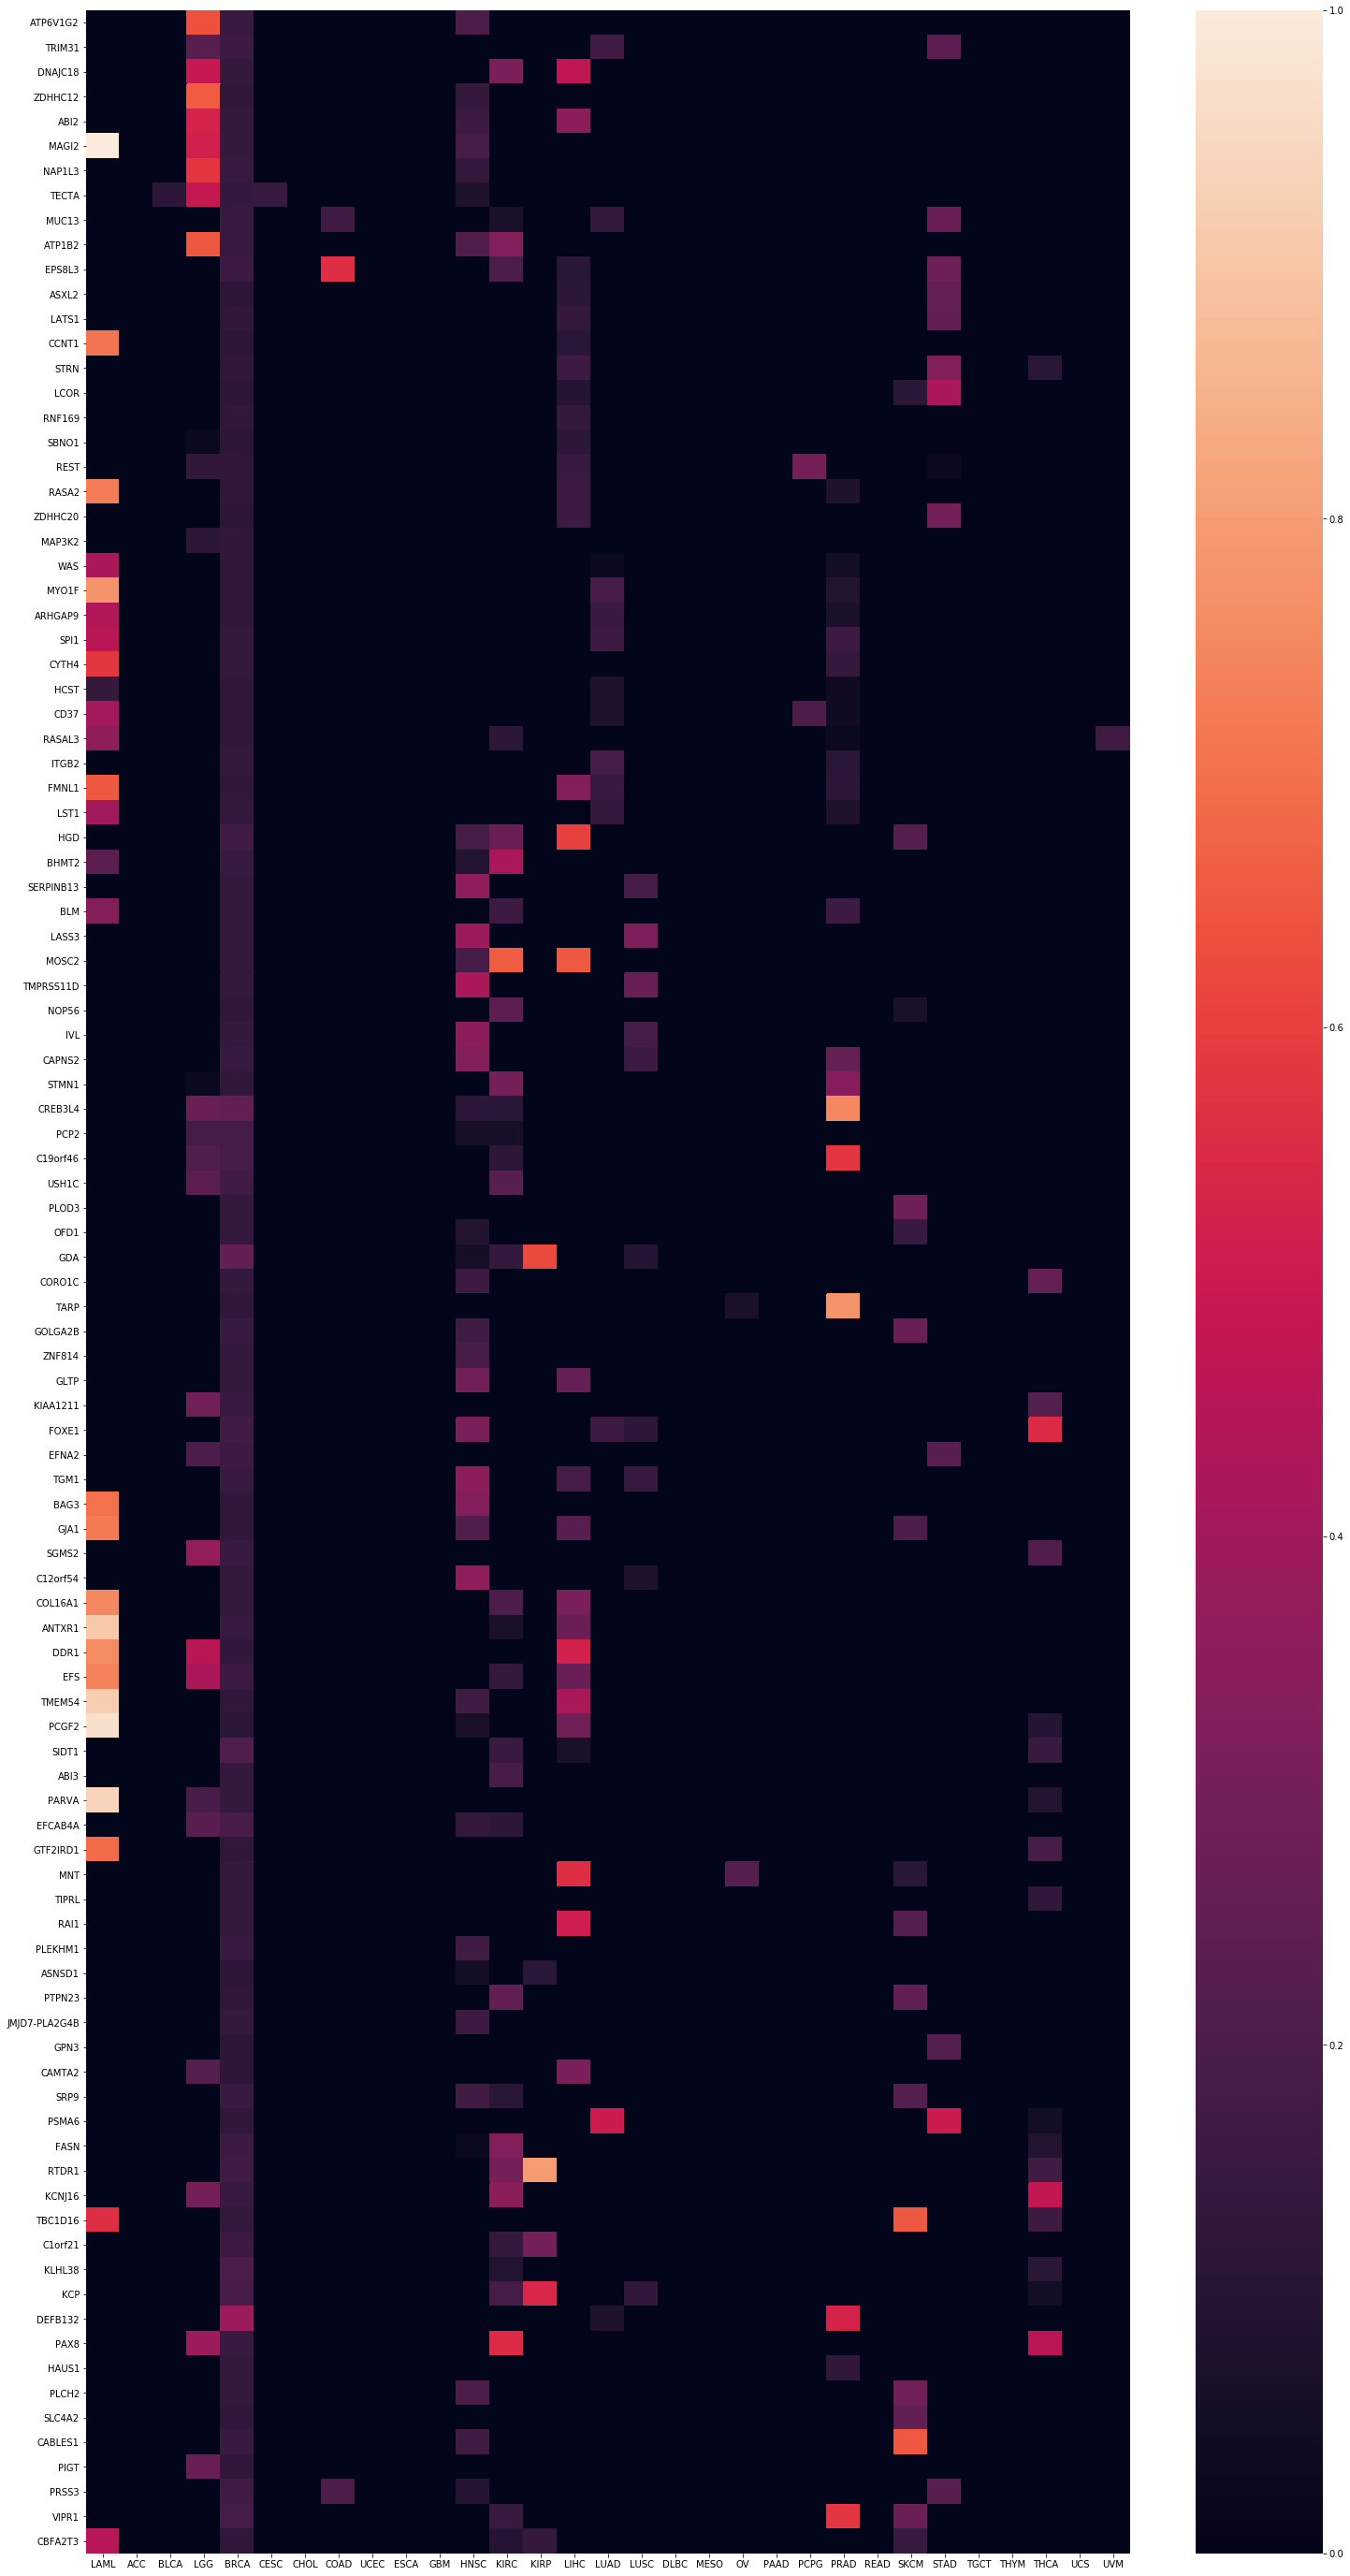

In [29]:
fig = plt.figure(figsize=(25,50))
sns.heatmap(df_precision.astype('float32').round(2))
#fig.savefig('Desktop/paper_figures/'+str('precision')+'.pdf', format='pdf', dpi=600,bbox_inches='tight')
plt.show()

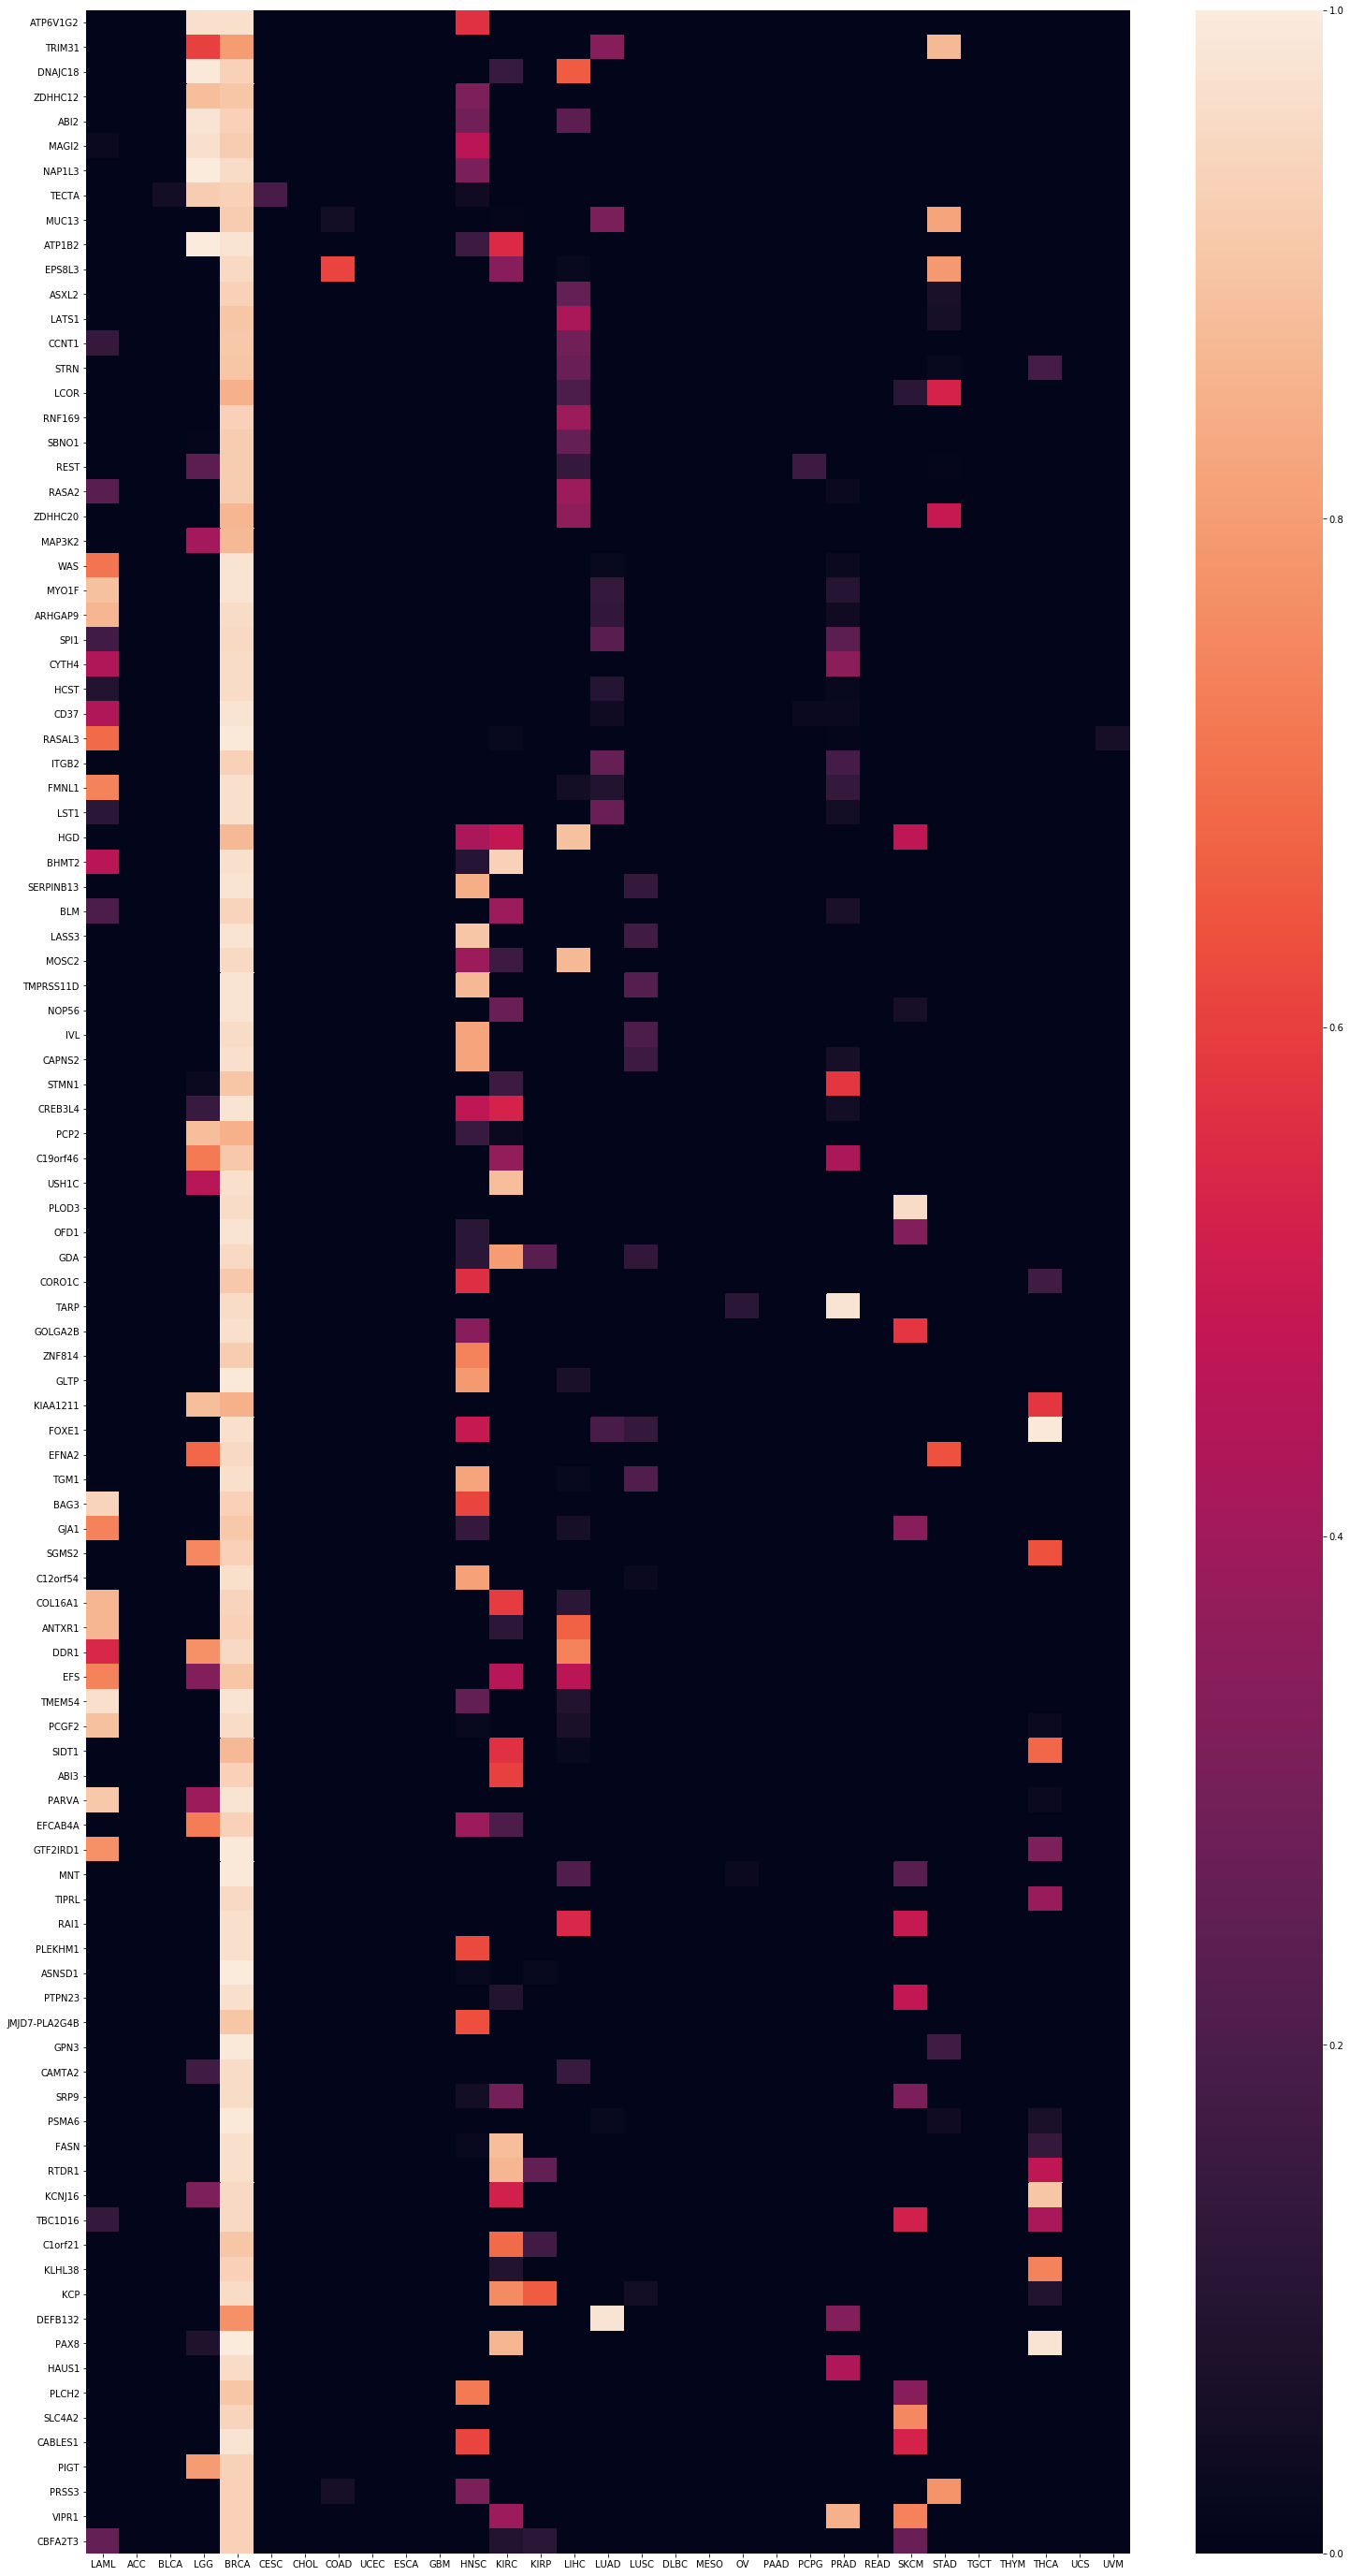

In [30]:
fig = plt.figure(figsize=(25,50))
sns.heatmap(df_recall.astype('float32').round(2))
#fig.savefig('Desktop/paper_figures/'+str('recall')+'.pdf', format='pdf', dpi=600,bbox_inches='tight')
plt.show()

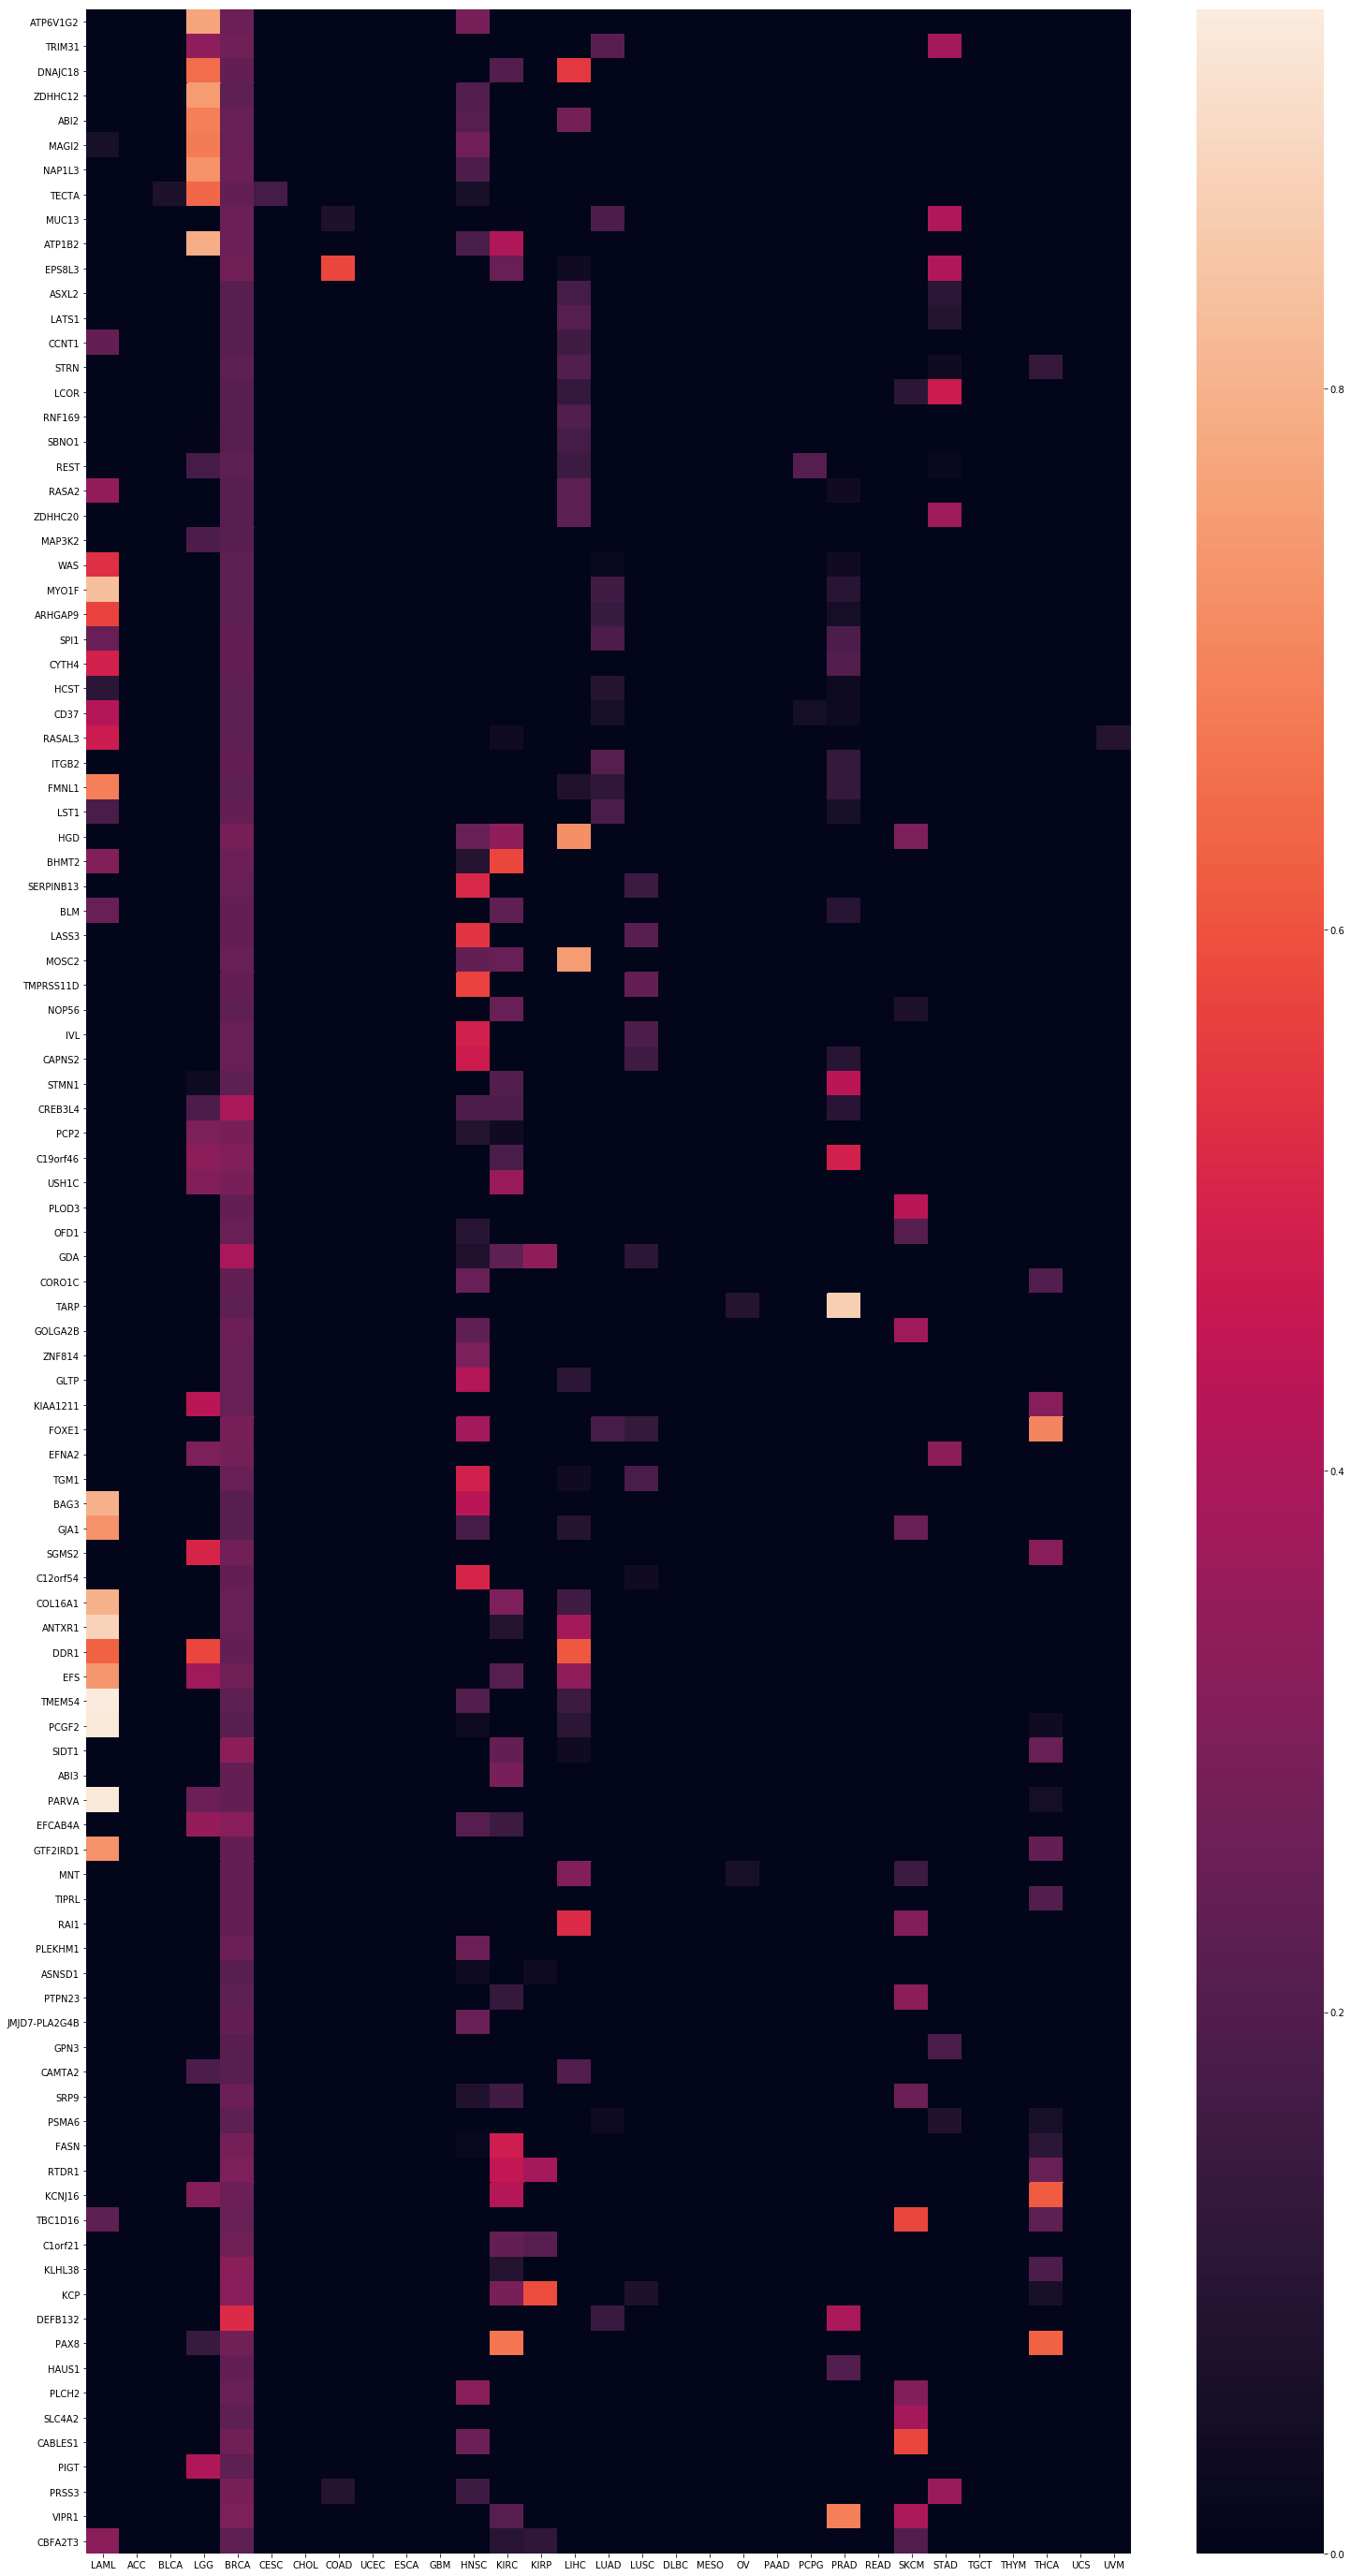

In [31]:
fig = plt.figure(figsize=(25,50))
sns.heatmap(df_fscore.astype('float32').round(2))
#fig.savefig('Desktop/paper_figures/'+str('fscore')+'.pdf', format='pdf', dpi=600,bbox_inches='tight')
plt.show()

# Boxplots of expression level of genes

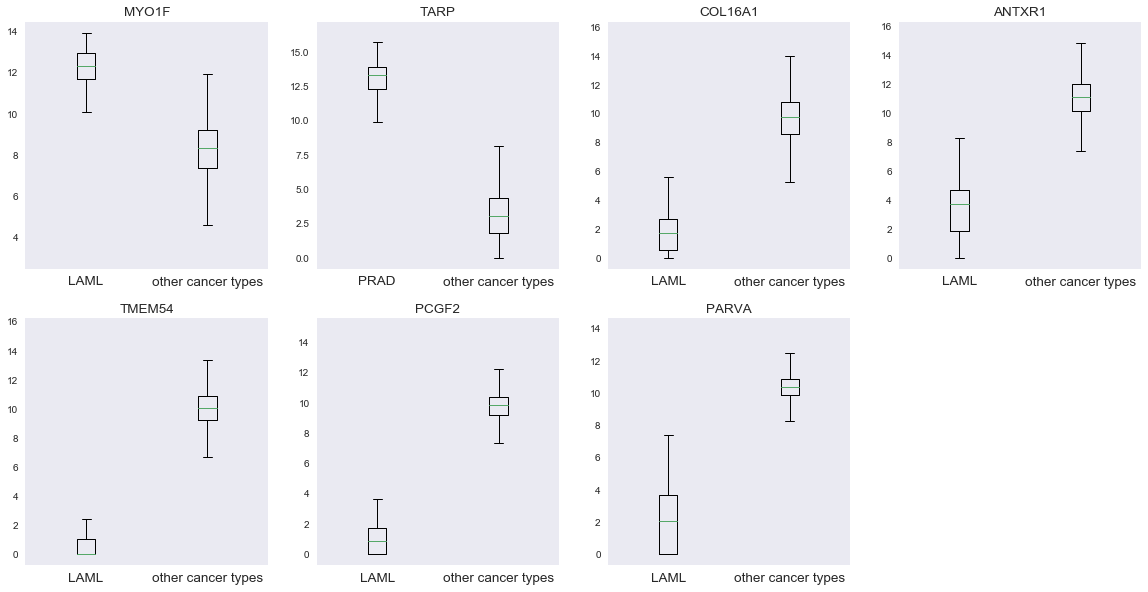

In [140]:
#sns.set_style('dark')
index= list_index#[14, 22, 0, 0, 0, 0, 0, 30]
list_genes = gene_list
cancer_types = l_str_label
fig = plt.figure(figsize=(20,10))
for i in range(len(index)):
    arr = df_pca2[df_pca2['label'] == index[i]][list_genes[i]]
    arr1 = df_pca2[df_pca2['label'] != index[i]][list_genes[i]]
    ax1 = fig.add_subplot(2,4,i+1)
    ax1.boxplot([arr,arr1])
    ax1.set_xticklabels([cancer_types[i],'other cancer types'],fontsize=13.5)
    ax1.set_title(list_genes[i],fontsize=13.5)
fig.savefig('Desktop/paper_figures/'+str('boxplots')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

In [33]:
import seaborn as sns
sns.set()

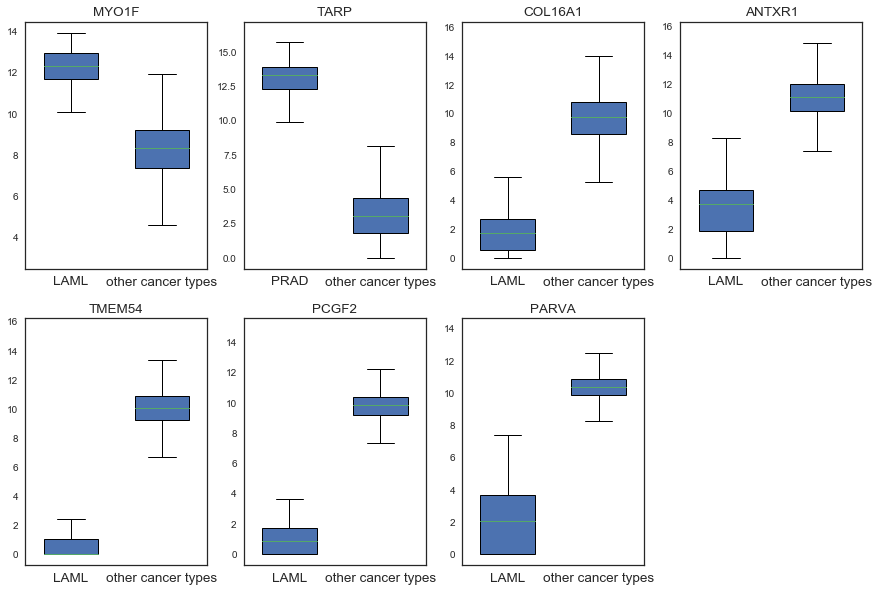

In [108]:
sns.set_style('white')
index= list_index#[14, 22, 0, 0, 0, 0, 0, 30]
list_genes = gene_list
cancer_types = l_str_label
fig = plt.figure(figsize=(15,10))
for i in range(len(index)):
    arr = df_pca2[df_pca2['label'] == index[i]][list_genes[i]]
    arr1 = df_pca2[df_pca2['label'] != index[i]][list_genes[i]]
    ax1 = fig.add_subplot(2,4,i+1)
    ax1.boxplot([arr,arr1],patch_artist=True,widths=0.6)
    ax1.set_xticklabels([cancer_types[i],'other cancer types'],fontsize=13.5)
    ax1.set_title(list_genes[i],fontsize=13.5)
    
    colors = ['pink', 'lightblue', 'lightgreen']
    for bplot in (bplot1, bplot2):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
#fig.savefig('Desktop/paper_figures/'+str('boxplots')+'.pdf', format='pdf', dpi=1200,bbox_inches='tight')
plt.show()

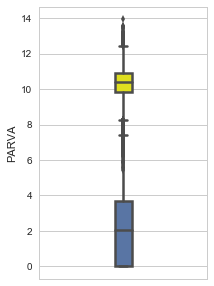

In [95]:
plt.figure(figsize=(3,5))

sns.boxplot(arr,orient='v',linewidth=2.5,width=0.1,order=np.arange(0,2))
sns.boxplot(arr1,color='yellow',orient='v',linewidth=2.5,width=0.1,order=np.arange(0,2))

AttributeError: 'NoneType' object has no attribute 'remove'

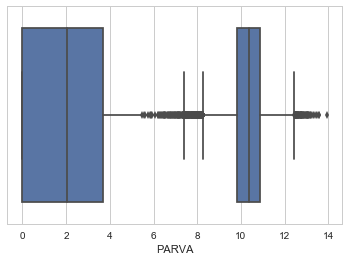

In [92]:
fig, ax = plt.subplots()
array = [arr,arr1]
# Loop the DataFrames and plot
for n in range(2):
    ax = sns.boxplot(array[n])
ax.legend_.remove()
plt.show()

In [53]:
df_temp=pd.DataFrame()
df_temp['LAML'] = list(arr)
df_temp['other cancer types'] = list(arr1)

ValueError: Length of values does not match length of index